In [ ]:
from cropnet.data_downloader import DataDownloader
import os
from herbie import Herbie
from datetime import datetime

# Use the "target_dir" to specify where the data should be downloaded to
downloader = DataDownloader(target_dir="./data")

# Download 2022 USDA Soybean data
# Note that most of the 2023 USDA data are not yet available
downloader.download_USDA("Soybean", fips_codes=["10003", "22007"], years=["2022"])

# Download the 2023 (the 1st and 2nd quarters) Sentinel-2 Imagery
downloader.download_Sentinel2(fips_codes=["10003", "22007"], years=["2023"], image_type="AG")
downloader.download_Sentinel2(fips_codes=["10003", "22007"], years=["2023"], image_type="NDVI")


# --- CONFIG ---
fips_codes = {
    "10003": "DE",  # Delaware - New Castle
    "22007": "LA",  # Louisiana - Assumption
}
date = "2023-01-01"
forecast_hour = "f00"  # Initial forecast only

# --- MAIN ---
for fips, state in fips_codes.items():
    output_dir = f"data/HRRR/realtime_wrf/2023/20230101"

    # Forecast times: 00 UTC to 23 UTC
    for hour in range(24):
        run_time = datetime.strptime(f"{date} {hour:02d}", "%Y-%m-%d %H")

        # Initialize Herbie
        H = Herbie(
            date=run_time,
            model="hrrr",
            product="sfc",
            fxx=0,  # f00 forecast
            save_dir=output_dir,
            verbose=True,
        )

        # Define output filename
        filename = f"hrrr.{date.replace('-', '')}.{hour:02d}.00.grib2"
        file_path = os.path.join(output_dir, filename)

        # Skip if file exists
        if os.path.exists(file_path):
            print(f"✅ File exists, skipping: {file_path}")
            continue

        # Download the file
        try:
            # Download and get the original file path
            downloaded_file = H.download()

            if downloaded_file and os.path.exists(downloaded_file):
                final_path = os.path.join(output_dir, f"hrrr.{run_time:%Y%m%d}.{run_time:%H}.00.grib2")
                os.rename(downloaded_file, final_path)
                print(f"✅ Renamed: {downloaded_file} -> {final_path}")
            else:
                print(f"⚠️ File not found after download: {downloaded_file}")
        except Exception as e:
            print(f"❌ Failed at {file_path}: {e}")



In [ ]:
# Use the "base_fir" to specify where the CropNet data is stored
retriever = DataRetriever(base_dir="/mnt/data/CropNet")
   
# Retrieve the 2022 USDA Soybean data
usda_data = retriever.retrieve_USDA(crop_type="Soybean", fips_codes=["10003", "22007"], years=["2022"])
   
# Retrieve the 2022 Sentinel-2 Imagery data
sentinel2_data = retriever.retrieve_Sentinel2(fips_codes=["10003", "22007"], years=["2022"], image_type="AG")
sentinel2_data = retriever.retrieve_Sentinel2(fips_codes=["10003", "22007"], years=["2022"], image_type="NDVI")
   
# Retrieve the 2022 WRF-HRRR data
hrrr_data = retriever.retrieve_HRRR(fips_codes=["10003","22007"], years=["2022"])

In [1]:
import pandas as pd
from functools import reduce

# --- 0. Read the USDA Corn, Cotton, Winter Wheat, Soybeans 2022 datasets ---
raw_usda_corn_path = '/Users/RavenMott1/Downloads/Cropnet/data/USDA Crop Dataset/data/Corn/2022/USDA_Corn_County_2022.csv'
raw_usda_cotton_path = '/Users/RavenMott1/Downloads/Cropnet/data/USDA Crop Dataset/data/Cotton/2022/USDA_Cotton_County_2022.csv'
raw_usda_winter_wheat_path = '/Users/RavenMott1/Downloads/Cropnet/data/USDA Crop Dataset/data/WinterWheat/2022/USDA_WinterWheat_County_2022.csv'
raw_usda_soybeans_path = '/Users/RavenMott1/Downloads/Cropnet/data/USDA Crop Dataset/data/Soybeans/2022/USDA_Soybean_County_2022.csv'

# Read each crop data into DataFrames
raw_usda_corn_df = pd.read_csv(raw_usda_corn_path)
raw_usda_cotton_df = pd.read_csv(raw_usda_cotton_path)
raw_usda_winter_wheat_df = pd.read_csv(raw_usda_winter_wheat_path)
raw_usda_soybeans_df = pd.read_csv(raw_usda_soybeans_path)

# --- 1. Filter for Alabama for all crop datasets ---
raw_usda_corn_df = raw_usda_corn_df[raw_usda_corn_df["state_name"].str.upper() == "ALABAMA"]
raw_usda_cotton_df = raw_usda_cotton_df[raw_usda_cotton_df["state_name"].str.upper() == "ALABAMA"]
raw_usda_winter_wheat_df = raw_usda_winter_wheat_df[raw_usda_winter_wheat_df["state_name"].str.upper() == "ALABAMA"]
raw_usda_soybeans_df = raw_usda_soybeans_df[raw_usda_soybeans_df["state_name"].str.upper() == "ALABAMA"]

# --- 2. Rename columns to be crop-specific ---
raw_usda_corn_df = raw_usda_corn_df.rename(columns={
    "YIELD, MEASURED IN BU / ACRE": "Corn_Yield_BU_ACRE",
    "PRODUCTION, MEASURED IN BU": "Corn_Production_BU"
})
raw_usda_cotton_df = raw_usda_cotton_df.rename(columns={
    "YIELD, MEASURED IN LB / ACRE": "Cotton_Yield_LB_ACRE",
    "PRODUCTION, MEASURED IN 480 LB BALES": "Cotton_Production_480LB_BALES"
})
raw_usda_winter_wheat_df = raw_usda_winter_wheat_df.rename(columns={
    "YIELD, MEASURED IN BU / ACRE": "WinterWheat_Yield_BU_ACRE",
    "PRODUCTION, MEASURED IN BU": "WinterWheat_Production_BU"
})
raw_usda_soybeans_df = raw_usda_soybeans_df.rename(columns={
    "YIELD, MEASURED IN BU / ACRE": "Soybeans_Yield_BU_ACRE",
    "PRODUCTION, MEASURED IN BU": "Soybeans_Production_BU"
})

# --- 3. Build a master location DataFrame from all datasets ---
location_dfs = [
    raw_usda_corn_df[["county_name", "state_name", "state_ansi", "county_ansi"]],
    raw_usda_cotton_df[["county_name", "state_name", "state_ansi", "county_ansi"]],
    raw_usda_winter_wheat_df[["county_name", "state_name", "state_ansi", "county_ansi"]],
    raw_usda_soybeans_df[["county_name", "state_name", "state_ansi", "county_ansi"]],
]
location_master_df = pd.concat(location_dfs, ignore_index=True).drop_duplicates(subset="county_name")

# --- 4. Prepare crop-specific DataFrames for merge ---
dfs = [
    raw_usda_corn_df[["county_name", "Corn_Yield_BU_ACRE", "Corn_Production_BU"]],
    raw_usda_cotton_df[["county_name", "Cotton_Yield_LB_ACRE", "Cotton_Production_480LB_BALES"]],
    raw_usda_winter_wheat_df[["county_name", "WinterWheat_Yield_BU_ACRE", "WinterWheat_Production_BU"]],
    raw_usda_soybeans_df[["county_name", "Soybeans_Yield_BU_ACRE", "Soybeans_Production_BU"]]
]

# Merge all crop data by county_name with outer join to keep all counties from all datasets
usda_all_crops_df = reduce(lambda left, right: pd.merge(left, right, on="county_name", how="outer"), dfs)

# --- 5. Merge the master location data to get complete state_name/state_ansi/county_ansi ---
usda_all_crops_df = pd.merge(
    usda_all_crops_df,
    location_master_df,
    on="county_name",
    how="left"
)

# --- 6. Create FIPS using state and county ANSI ---
if "state_ansi" in usda_all_crops_df.columns and "county_ansi" in usda_all_crops_df.columns:
    usda_all_crops_df["FIPS"] = (
        usda_all_crops_df["state_ansi"].astype(pd.Int64Dtype()).astype(str).str.zfill(2) +
        usda_all_crops_df["county_ansi"].astype(pd.Int64Dtype()).astype(str).str.zfill(3)
    )

# --- 7. Group by county_name to handle duplicates, aggregate numeric fields by mean, others by first ---
agg_dict = {
    col: "mean" for col in usda_all_crops_df.select_dtypes(include="number").columns
    if col not in ["state_ansi", "county_ansi"]
}
# Also keep the first non-null value for these identifier fields
for col in ["state_name", "state_ansi", "county_ansi", "FIPS"]:
    if col in usda_all_crops_df.columns:
        agg_dict[col] = "first"

usda_all_crops_grouped = usda_all_crops_df.groupby("county_name", as_index=False).agg(agg_dict)


# List of HRRR monthly file paths for AL, 2022
hrrr_month_paths = [
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-01.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-02.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 7/data/2022/AL/HRRR_01_AL_2022-03.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-04.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-05.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-06.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-07.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-08.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-09.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-10.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-11.csv',
    '/Users/RavenMott1/Downloads/Cropnet/data/New Folder With Items/WRF-HRRR Computed Dataset 14/data/2022/AL/HRRR_01_AL_2022-12.csv'
]

# Read each monthly file into a DataFrame and combine them
hrrr_monthly_dfs = [pd.read_csv(path) for path in hrrr_month_paths]
hrrr_all_year_df = pd.concat(hrrr_monthly_dfs, ignore_index=True)









In [2]:
usda_all_crops_grouped

county_name  Corn_Yield_BU_ACRE  Corn_Production_BU  Cotton_Yield_LB_ACRE  \
0      AUTAUGA                 NaN                 NaN                 972.0   
1      BALDWIN               139.0           1020000.0                 782.0   
2      BARBOUR               159.8            262000.0                 932.0   
3       BLOUNT               100.4            242000.0                   NaN   
4      CALHOUN               142.4            319000.0                1183.0   
5     CHEROKEE               138.5            633000.0                1147.0   
6      CHILTON                92.4             75800.0                   NaN   
7       COFFEE               125.4            602000.0                 739.0   
8      COLBERT                94.0           1607000.0                 871.0   
9    COVINGTON                 NaN                 NaN                 945.0   
10     CULLMAN               134.4            363000.0                   NaN   
11        DALE               128.2            200000.0                 774.0   
12      DALLAS               111.3            503000.0                 892.0   
13     DE KALB               144.3           1760000.0                1219.0   
14    ESCAMBIA               167.1           1136000.0                 888.0   
15      ETOWAH               132.4            384000.0                1071.0   
16     FAYETTE               101.5            187800.0                   NaN   
17      GENEVA                 NaN                 NaN                 813.0   
18       HENRY               161.4            468000.0                 813.0   
19     HOUSTON               160.3            452000.0                 754.0   
20     JACKSON               110.7           2546000.0                   NaN   
21  LAUDERDALE                83.0           1959000.0                1098.0   
22    LAWRENCE                96.3           3216000.0                1075.0   
23         LEE                 NaN                 NaN                 965.0   
24   LIMESTONE               117.2           2672000.0                1093.0   
25       MACON                 NaN                 NaN                 993.0   
26     MADISON               152.5           3995000.0                1230.0   
27     MARENGO                60.4             70100.0                   NaN   
28      MARION               120.1            221000.0                   NaN   
29    MARSHALL               123.2            691000.0                   NaN   
30      MOBILE                 NaN                 NaN                 703.0   
31      MONROE               132.2            484000.0                 712.0   
32      MORGAN                89.3            467000.0                   NaN   
33       PERRY                68.0            434000.0                   NaN   
34        PIKE                 NaN                 NaN                 799.0   
35    RANDOLPH               139.9            131500.0                   NaN   
36     RUSSELL                99.2             60500.0                   NaN   
37      SHELBY                 NaN                 NaN                 906.0   
38   TALLADEGA               154.9            824000.0                1124.0   
39  TUSCALOOSA               120.8            256000.0                 992.0   

    Cotton_Production_480LB_BALES  WinterWheat_Yield_BU_ACRE  \
0                         15900.0                        NaN   
1                         16300.0                        NaN   
2                         12200.0                        NaN   
3                             NaN                        NaN   
4                         10200.0                        NaN   
5                         59500.0                        NaN   
6                             NaN                        NaN   
7                         25700.0                        NaN   
8                         19600.0                        NaN   
9                         31900.0                        NaN   
10                

In [3]:
usda_all_crops_grouped.head()


county_name  Corn_Yield_BU_ACRE  Corn_Production_BU  Cotton_Yield_LB_ACRE  \
0     AUTAUGA                 NaN                 NaN                 972.0   
1     BALDWIN               139.0           1020000.0                 782.0   
2     BARBOUR               159.8            262000.0                 932.0   
3      BLOUNT               100.4            242000.0                   NaN   
4     CALHOUN               142.4            319000.0                1183.0   

   Cotton_Production_480LB_BALES  WinterWheat_Yield_BU_ACRE  \
0                        15900.0                        NaN   
1                        16300.0                        NaN   
2                        12200.0                        NaN   
3                            NaN                        NaN   
4                        10200.0                        NaN   

   WinterWheat_Production_BU  Soybeans_Yield_BU_ACRE  Soybeans_Production_BU  \
0                        NaN                     NaN                     NaN   
1                        NaN                    37.1                445000.0   
2                        NaN                     NaN                     NaN   
3                        NaN                    37.4                 96900.0   
4                        NaN                    45.5                132000.0   

  state_name  state_ansi  county_ansi   FIPS  
0    ALABAMA           1            1  01001  
1    ALABAMA           1            3  01003  
2    ALABAMA           1            5  01005  
3    ALABAMA           1            9  01009  
4    ALABAMA           1           15  01015

In [4]:
usda_all_crops_grouped.tail()

county_name  Corn_Yield_BU_ACRE  Corn_Production_BU  Cotton_Yield_LB_ACRE  \
35    RANDOLPH               139.9            131500.0                   NaN   
36     RUSSELL                99.2             60500.0                   NaN   
37      SHELBY                 NaN                 NaN                 906.0   
38   TALLADEGA               154.9            824000.0                1124.0   
39  TUSCALOOSA               120.8            256000.0                 992.0   

    Cotton_Production_480LB_BALES  WinterWheat_Yield_BU_ACRE  \
35                            NaN                        NaN   
36                            NaN                        NaN   
37                         7890.0                        NaN   
38                        18100.0                        NaN   
39                         3700.0                        NaN   

    WinterWheat_Production_BU  Soybeans_Yield_BU_ACRE  Soybeans_Production_BU  \
35                        NaN                     NaN                     NaN   
36                        NaN                     NaN                     NaN   
37                        NaN                     NaN                     NaN   
38                        NaN                    46.3                328000.0   
39                        NaN                    39.2                164000.0   

   state_name  state_ansi  county_ansi   FIPS  
35    ALABAMA           1          111  01111  
36    ALABAMA           1          113  01113  
37    ALABAMA           1          117  01117  
38    ALABAMA           1          121  01121  
39    ALABAMA           1          125  01125

In [5]:
hrrr_all_year_df.head()


Year  Month  Day Daily/Monthly    State   County  FIPS Code  Grid Index  \
0  2022      1  1.0         Daily  ALABAMA  AUTAUGA       1001         0.0   
1  2022      1  2.0         Daily  ALABAMA  AUTAUGA       1001         0.0   
2  2022      1  3.0         Daily  ALABAMA  AUTAUGA       1001         0.0   
3  2022      1  4.0         Daily  ALABAMA  AUTAUGA       1001         0.0   
4  2022      1  5.0         Daily  ALABAMA  AUTAUGA       1001         0.0   

   Lat (llcrnr)  Lon (llcrnr)  ...  Max Temperature (K)  Min Temperature (K)  \
0     32.340803    -86.917595  ...              301.218              294.130   
1     32.340803    -86.917595  ...              297.836              286.795   
2     32.340803    -86.917595  ...              285.739              274.121   
3     32.340803    -86.917595  ...              285.378              272.304   
4     32.340803    -86.917595  ...              289.256              274.308   

   Precipitation (kg m**-2)  Relative Humidity (%)  Wind Gust (m s**-1)  \
0                     0.015                   78.8                9.299   
1                    44.044                   83.9                9.476   
2                    10.555                   81.6               11.557   
3                     0.000                   78.5                4.403   
4                     0.000                   83.3                2.393   

   Wind Speed (m s**-1)  U Component of Wind (m s**-1)  \
0                 6.181                          1.113   
1                 4.003                          1.462   
2                 9.861                          6.925   
3                 3.956                         -0.871   
4                 3.235                          0.656   

   V Component of Wind (m s**-1)  Downward Shortwave Radiation Flux (W m**-2)  \
0                          6.019                                       2717.9   
1                          2.034                                        234.9   
2                         -6.421                                        546.8   
3                         -1.211                                       3538.8   
4                          2.695                                       2874.2   

   Vapor Pressure Deficit (kPa)  
0                         0.680  
1                         0.429  
2                         0.142  
3                         0.210  
4                         0.220  

[5 rows x 23 columns]

In [6]:
hrrr_all_year_df.tail()

Year  Month  Day Daily/Monthly    State      County  FIPS Code  \
574579  2022     12  NaN       Monthly  ALABAMA  TUSCALOOSA       1125   
574580  2022     12  NaN       Monthly  ALABAMA      WALKER       1127   
574581  2022     12  NaN       Monthly  ALABAMA  WASHINGTON       1129   
574582  2022     12  NaN       Monthly  ALABAMA      WILCOX       1131   
574583  2022     12  NaN       Monthly  ALABAMA     WINSTON       1133   

        Grid Index  Lat (llcrnr)  Lon (llcrnr)  ...  Max Temperature (K)  \
574579         NaN           NaN           NaN  ...           288.185181   
574580         NaN           NaN           NaN  ...           287.240032   
574581         NaN           NaN           NaN  ...           290.631626   
574582         NaN           NaN           NaN  ...           289.999109   
574583         NaN           NaN           NaN  ...           285.928077   

        Min Temperature (K)  Precipitation (kg m**-2)  Relative Humidity (%)  \
574579           279.229789                  2.826740              72.746851   
574580           278.496918                  3.751461              74.763479   
574581           280.754182                  2.329830              75.409789   
574582           279.922981                  2.333949              74.402289   
574583           277.814700                  4.431048              76.342903   

        Wind Gust (m s**-1)  Wind Speed (m s**-1)  \
574579             5.961694              4.350012   
574580             5.758985              3.341762   
574581             5.289463              5.312858   
574582             5.376633              5.221529   
574583             6.173765              2.460526   

        U Component of Wind (m s**-1)  V Component of Wind (m s**-1)  \
574579                      -0.130550                       0.602714   
574580                      -0.018359                       0.416022   
574581                      -0.510805                      -0.242010   
574582                      -0.206868                       0.539279   
574583                       0.139326                       0.481694   

        Downward Shortwave Radiation Flux (W m**-2)  \
574579                                  2099.143088   
574580                                  1913.495507   
574581                                  2341.741046   
574582                                  2362.406139   
574583                                  1814.203548   

        Vapor Pressure Deficit (kPa)  
574579                      0.325164  
574580                      0.278380  
574581                      0.326270  
574582                      0.335264  
574583                      0.238365  

[5 rows x 23 columns]

In [7]:

print("Unique counties:", hrrr_all_year_df["County"].unique())
print("Number of unique counties:", hrrr_all_year_df["County"].nunique())

Unique counties: ['AUTAUGA' 'BALDWIN' 'BARBOUR' 'BIBB' 'BLOUNT' 'BULLOCK' 'BUTLER'
 'CALHOUN' 'CHAMBERS' 'CHEROKEE' 'CHILTON' 'CHOCTAW' 'CLARKE' 'CLAY'
 'CLEBURNE' 'COFFEE' 'COLBERT' 'CONECUH' 'COOSA' 'COVINGTON' 'CRENSHAW'
 'CULLMAN' 'DALE' 'DALLAS' 'DEKALB' 'ELMORE' 'ESCAMBIA' 'ETOWAH' 'FAYETTE'
 'FRANKLIN' 'GENEVA' 'GREENE' 'HALE' 'HENRY' 'HOUSTON' 'JACKSON'
 'JEFFERSON' 'LAMAR' 'LAUDERDALE' 'LAWRENCE' 'LEE' 'LIMESTONE' 'LOWNDES'
 'MACON' 'MADISON' 'MARENGO' 'MARION' 'MARSHALL' 'MOBILE' 'MONROE'
 'MONTGOMERY' 'MORGAN' 'PERRY' 'PICKENS' 'PIKE' 'RANDOLPH' 'RUSSELL'
 'SHELBY' 'ST. CLAIR' 'SUMTER' 'TALLADEGA' 'TALLAPOOSA' 'TUSCALOOSA'
 'WALKER' 'WASHINGTON' 'WILCOX' 'WINSTON']
Number of unique counties: 67


In [8]:
# Number of rows and columns
print("usda_all_crops_grouped shape:", usda_all_crops_grouped.shape)
print("hrrr_all_year_df shape:", hrrr_all_year_df.shape)

# Data types
print("\nusda_all_crops_grouped data types:\n", usda_all_crops_grouped.dtypes)
print("\nhrrr_all_year_df data types:\n", hrrr_all_year_df.dtypes)

# Check for missing values
print("\nusda_all_crops_grouped missing values:\n", usda_all_crops_grouped.isnull().sum())
print("\nhrrr_all_year_df missing values:\n", hrrr_all_year_df.isnull().sum())

# Quick summary of categorical and numerical columns
print("\nusda_all_crops_grouped categorical columns:", usda_all_crops_grouped.select_dtypes(include='object').columns.tolist())
print("usda_all_crops_grouped numerical columns:", usda_all_crops_grouped.select_dtypes(include=['number']).columns.tolist())

print("\nhrrr_all_year_df categorical columns:", hrrr_all_year_df.select_dtypes(include='object').columns.tolist())
print("hrrr_all_year_df numerical columns:", hrrr_all_year_df.select_dtypes(include=['number']).columns.tolist())


usda_all_crops_grouped shape: (40, 13)
hrrr_all_year_df shape: (574584, 23)

usda_all_crops_grouped data types:
 county_name                       object
Corn_Yield_BU_ACRE               float64
Corn_Production_BU               float64
Cotton_Yield_LB_ACRE             float64
Cotton_Production_480LB_BALES    float64
WinterWheat_Yield_BU_ACRE        float64
WinterWheat_Production_BU        float64
Soybeans_Yield_BU_ACRE           float64
Soybeans_Production_BU           float64
state_name                        object
state_ansi                         int64
county_ansi                        int64
FIPS                              object
dtype: object

hrrr_all_year_df data types:
 Year                                             int64
Month                                            int64
Day                                            float64
Daily/Monthly                                   object
State                                           object
County                            

In [9]:
# Data Cleaning and Standardization



# --- 3. Standardize county/state names (uppercase, no extra spaces) ---
def standardize_location_names(df, county_col="County", state_col="State"):
    if county_col in df.columns:
        df[county_col] = df[county_col].astype(str).str.strip().str.upper()
    if state_col in df.columns:
        df[state_col] = df[state_col].astype(str).str.strip().str.upper()
    return df

usda_all_crops_grouped = standardize_location_names(usda_all_crops_grouped, county_col="county_name", state_col="state_name")
hrrr_all_year_df= standardize_location_names(hrrr_all_year_df, county_col="County", state_col="State")

# --- 4. Convert temperature values from Kelvin to Celsius ---
temp_k_map = {
    "Avg Temperature (K)": "Avg Temperature (C)",
    "Max Temperature (K)": "Max Temperature (C)",
    "Min Temperature (K)": "Min Temperature (C)"
}
for k_col, c_col in temp_k_map.items():
    if k_col in hrrr_all_year_df.columns:
        hrrr_all_year_df[c_col] = hrrr_all_year_df[k_col] - 273.15 # Convert Kelvin to Celsius
        del hrrr_all_year_df[k_col]

# --- 5. Split daily and monthly data into separate DataFrames ---
is_monthly = hrrr_all_year_df["Daily/Monthly"].str.upper() == "MONTHLY"
hrrr_every_month_df = hrrr_all_year_df[is_monthly].reset_index(drop=True)
hrrr_all_year_df = hrrr_all_year_df[~is_monthly].reset_index(drop=True)

for df in [hrrr_all_year_df, hrrr_every_month_df]:
    if "Daily/Monthly" in df.columns:
        del df["Daily/Monthly"]

# Add "Date" column for daily data if year, month, day columns exist
if all(col in hrrr_all_year_df.columns for col in ["Year", "Month", "Day"]):
    hrrr_all_year_df["Date"] = pd.to_datetime(hrrr_all_year_df[["Year", "Month", "Day"]], errors="coerce")

# Add "Date" column for monthly data if year and month columns exist
if all(col in hrrr_every_month_df.columns for col in ["Year", "Month"]):
    hrrr_every_month_df["Date"] = pd.to_datetime(
        dict(
            year=hrrr_every_month_df["Year"],
            month=hrrr_every_month_df["Month"],
            day=1
        ),
        errors="coerce"
    )

# Group by State, County, and Date to keep daily granularity
hrrr_all_year_df = hrrr_all_year_df.groupby(["State", "County", "Date"], as_index=False).mean(numeric_only=True)

# Standardize FIPS codes in HRRR data to match USDA (5-digit, zero-padded string)
for df in [hrrr_all_year_df, hrrr_every_month_df]:
    if "FIPS Code" in df.columns:
        df["FIPS"] = df["FIPS Code"].astype(int).astype(str).str.zfill(5)

# --- 6. Remove unnecessary columns ---
remove_cols = [
    "Lat (llcrnr)", "Lon (llcrnr)", "Lat (urcrnr)", "Lon (urcrnr)",
    "Year", "Month", "Day", "Daily/Monthly", "state_ansi", "county_ansi",
    "FIPS Code", "Grid Index", "Grid Index (Monthly)"
]
for df in [hrrr_all_year_df, hrrr_every_month_df, usda_all_crops_grouped]:
    for col in remove_cols:
        if col in df.columns:
            del df[col]


In [10]:
usda_all_crops_grouped.head()

county_name  Corn_Yield_BU_ACRE  Corn_Production_BU  Cotton_Yield_LB_ACRE  \
0     AUTAUGA                 NaN                 NaN                 972.0   
1     BALDWIN               139.0           1020000.0                 782.0   
2     BARBOUR               159.8            262000.0                 932.0   
3      BLOUNT               100.4            242000.0                   NaN   
4     CALHOUN               142.4            319000.0                1183.0   

   Cotton_Production_480LB_BALES  WinterWheat_Yield_BU_ACRE  \
0                        15900.0                        NaN   
1                        16300.0                        NaN   
2                        12200.0                        NaN   
3                            NaN                        NaN   
4                        10200.0                        NaN   

   WinterWheat_Production_BU  Soybeans_Yield_BU_ACRE  Soybeans_Production_BU  \
0                        NaN                     NaN                     NaN   
1                        NaN                    37.1                445000.0   
2                        NaN                     NaN                     NaN   
3                        NaN                    37.4                 96900.0   
4                        NaN                    45.5                132000.0   

  state_name   FIPS  
0    ALABAMA  01001  
1    ALABAMA  01003  
2    ALABAMA  01005  
3    ALABAMA  01009  
4    ALABAMA  01015

In [11]:
usda_all_crops_grouped.tail()

county_name  Corn_Yield_BU_ACRE  Corn_Production_BU  Cotton_Yield_LB_ACRE  \
35    RANDOLPH               139.9            131500.0                   NaN   
36     RUSSELL                99.2             60500.0                   NaN   
37      SHELBY                 NaN                 NaN                 906.0   
38   TALLADEGA               154.9            824000.0                1124.0   
39  TUSCALOOSA               120.8            256000.0                 992.0   

    Cotton_Production_480LB_BALES  WinterWheat_Yield_BU_ACRE  \
35                            NaN                        NaN   
36                            NaN                        NaN   
37                         7890.0                        NaN   
38                        18100.0                        NaN   
39                         3700.0                        NaN   

    WinterWheat_Production_BU  Soybeans_Yield_BU_ACRE  Soybeans_Production_BU  \
35                        NaN                     NaN                     NaN   
36                        NaN                     NaN                     NaN   
37                        NaN                     NaN                     NaN   
38                        NaN                    46.3                328000.0   
39                        NaN                    39.2                164000.0   

   state_name   FIPS  
35    ALABAMA  01111  
36    ALABAMA  01113  
37    ALABAMA  01117  
38    ALABAMA  01121  
39    ALABAMA  01125

In [12]:
hrrr_all_year_df.head()

State   County       Date  Precipitation (kg m**-2)  \
0  ALABAMA  AUTAUGA 2022-01-01                  0.059533   
1  ALABAMA  AUTAUGA 2022-01-02                 39.259400   
2  ALABAMA  AUTAUGA 2022-01-03                  9.041000   
3  ALABAMA  AUTAUGA 2022-01-04                  0.000000   
4  ALABAMA  AUTAUGA 2022-01-05                  0.000000   

   Relative Humidity (%)  Wind Gust (m s**-1)  Wind Speed (m s**-1)  \
0              79.960000             9.857133              4.899000   
1              85.293333             9.312733              3.479667   
2              83.580000            11.858000              8.853067   
3              79.566667             5.126933              3.955267   
4              82.606667             2.826000              2.506533   

   U Component of Wind (m s**-1)  V Component of Wind (m s**-1)  \
0                       0.792800                       4.789800   
1                       0.991000                       1.738867   
2                       6.077667                      -5.822200   
3                      -0.940000                      -1.284133   
4                       0.393400                       2.080133   

   Downward Shortwave Radiation Flux (W m**-2)  Vapor Pressure Deficit (kPa)  \
0                                  2295.146667                      0.611533   
1                                   133.506667                      0.373400   
2                                   723.320000                      0.127133   
3                                  3618.586667                      0.185733   
4                                  3123.560000                      0.209800   

   Avg Temperature (C)  Max Temperature (C)  Min Temperature (C)   FIPS  
0            23.045200            27.026200            20.714200  01001  
1            19.398133            24.106600            14.366800  01001  
2             3.389400            13.730800             0.583800  01001  
3             2.955267            11.096467            -1.362067  01001  
4             7.253933            15.051667             1.555333  01001

In [13]:
hrrr_all_year_df.tail()

State   County       Date  Precipitation (kg m**-2)  \
24450  ALABAMA  WINSTON 2022-12-27                    0.0410   
24451  ALABAMA  WINSTON 2022-12-28                    0.0000   
24452  ALABAMA  WINSTON 2022-12-29                    0.0005   
24453  ALABAMA  WINSTON 2022-12-30                    4.9288   
24454  ALABAMA  WINSTON 2022-12-31                    2.9169   

       Relative Humidity (%)  Wind Gust (m s**-1)  Wind Speed (m s**-1)  \
24450                  60.73               2.9369                1.2523   
24451                  57.99               5.4309                2.3576   
24452                  54.37               7.7621                3.2297   
24453                  69.84               7.7498                2.9568   
24454                  90.05               5.3954                1.7232   

       U Component of Wind (m s**-1)  V Component of Wind (m s**-1)  \
24450                        -0.1579                         0.3555   
24451                        -0.8026                         1.9647   
24452                        -1.4674                         2.8359   
24453                        -1.7741                         2.2538   
24454                         0.2989                         1.3839   

       Downward Shortwave Radiation Flux (W m**-2)  \
24450                                      3500.11   
24451                                      3476.77   
24452                                      2927.08   
24453                                      1321.33   
24454                                      2035.42   

       Vapor Pressure Deficit (kPa)  Avg Temperature (C)  Max Temperature (C)  \
24450                        0.3125               1.4862               9.2741   
24451                        0.4240               3.6658              15.7081   
24452                        0.6962              12.5045              20.2341   
24453                        0.5042              14.5311              17.4595   
24454                        0.1916              15.2048              18.5266   

       Min Temperature (C)   FIPS  
24450              -4.3926  01133  
24451              -3.2121  01133  
24452               7.6635  01133  
24453              10.8967  01133  
24454              13.8078  01133

In [14]:
hrrr_every_month_df.head()

State   County  Precipitation (kg m**-2)  Relative Humidity (%)  \
0  ALABAMA  AUTAUGA                  3.830028              68.428817   
1  ALABAMA  BALDWIN                  1.841861              72.732998   
2  ALABAMA  BARBOUR                  2.799485              66.396344   
3  ALABAMA     BIBB                  4.264183              67.724395   
4  ALABAMA   BLOUNT                  3.703056              66.927074   

   Wind Gust (m s**-1)  Wind Speed (m s**-1)  U Component of Wind (m s**-1)  \
0             6.175469              4.755189                       0.429174   
1             6.853068              6.743207                       0.354913   
2             5.963249              4.273303                       0.557912   
3             6.401355              4.233808                       0.243683   
4             6.529457              3.103699                       0.424286   

   V Component of Wind (m s**-1)  Downward Shortwave Radiation Flux (W m**-2)  \
0                      -1.321458                                  2889.922151   
1                      -1.749422                                  3034.614490   
2                      -0.843831                                  3009.552258   
3                      -1.104087                                  2849.618750   
4                      -0.774506                                  2718.283641   

   Vapor Pressure Deficit (kPa)  Avg Temperature (C)  Max Temperature (C)  \
0                      0.355817             6.947680            14.001428   
1                      0.342061             9.283907            15.747453   
2                      0.417730             8.148353            15.404311   
3                      0.350008             6.504290            13.398339   
4                      0.318297             4.882684            11.411570   

   Min Temperature (C)       Date   FIPS  
0             1.938120 2022-01-01  01001  
1             4.303026 2022-01-01  01003  
2             2.615023 2022-01-01  01005  
3             1.634060 2022-01-01  01007  
4             0.300821 2022-01-01  01009

In [15]:
hrrr_every_month_df.tail()

State      County  Precipitation (kg m**-2)  Relative Humidity (%)  \
799  ALABAMA  TUSCALOOSA                  2.826740              72.746851   
800  ALABAMA      WALKER                  3.751461              74.763479   
801  ALABAMA  WASHINGTON                  2.329830              75.409789   
802  ALABAMA      WILCOX                  2.333949              74.402289   
803  ALABAMA     WINSTON                  4.431048              76.342903   

     Wind Gust (m s**-1)  Wind Speed (m s**-1)  U Component of Wind (m s**-1)  \
799             5.961694              4.350012                      -0.130550   
800             5.758985              3.341762                      -0.018359   
801             5.289463              5.312858                      -0.510805   
802             5.376633              5.221529                      -0.206868   
803             6.173765              2.460526                       0.139326   

     V Component of Wind (m s**-1)  \
799                       0.602714   
800                       0.416022   
801                      -0.242010   
802                       0.539279   
803                       0.481694   

     Downward Shortwave Radiation Flux (W m**-2)  \
799                                  2099.143088   
800                                  1913.495507   
801                                  2341.741046   
802                                  2362.406139   
803                                  1814.203548   

     Vapor Pressure Deficit (kPa)  Avg Temperature (C)  Max Temperature (C)  \
799                      0.325164             9.746571            15.035181   
800                      0.278380             8.949740            14.090032   
801                      0.326270            11.635430            17.481626   
802                      0.335264            10.938416            16.849109   
803                      0.238365             8.058665            12.778077   

     Min Temperature (C)       Date   FIPS  
799             6.079789 2022-12-01  01125  
800             5.346918 2022-12-01  01127  
801             7.604182 2022-12-01  01129  
802             6.772981 2022-12-01  01131  
803             4.664700 2022-12-01  01133

In [16]:
# Number of rows and columns
print("usda_all_crops_grouped shape:", usda_all_crops_grouped.shape)
print("hrrr_all_year_df shape:", hrrr_all_year_df.shape)
print("hrrr_every_month_df shape:", hrrr_every_month_df.shape)

# Data types
print("\nusda_all_crops_grouped data types:\n", usda_all_crops_grouped.dtypes)
print("\nhrrr_all_year_df data types:\n", hrrr_all_year_df.dtypes)
print("\nhrrr_every_month_df data types:\n", hrrr_every_month_df.dtypes)

# Check for missing values
print("\nusda_all_crops_grouped missing values:\n", usda_all_crops_grouped.isnull().sum())
print("\nhrrr_all_year_df missing values:\n", hrrr_all_year_df.isnull().sum())
print("\nhrrr_every_month_df missing values:\n", hrrr_every_month_df.isnull().sum())

# Quick summary of categorical and numerical columns
print("\nusda_all_crops_grouped categorical columns:", usda_all_crops_grouped.select_dtypes(include='object').columns.tolist())
print("usda_all_crops_grouped numerical columns:", usda_all_crops_grouped.select_dtypes(include=['number']).columns.tolist())

print("\nhrrr_all_year_df categorical columns:", hrrr_all_year_df.select_dtypes(include='object').columns.tolist())
print("hrrr_all_year_df numerical columns:", hrrr_all_year_df.select_dtypes(include=['number']).columns.tolist())

print("\nhrrr_every_month_df categorical columns:", hrrr_every_month_df.select_dtypes(include='object').columns.tolist())
print("hrrr_every_month_df numerical columns:", hrrr_every_month_df.select_dtypes(include=['number']).columns.tolist())

usda_all_crops_grouped shape: (40, 11)
hrrr_all_year_df shape: (24455, 15)
hrrr_every_month_df shape: (804, 15)

usda_all_crops_grouped data types:
 county_name                       object
Corn_Yield_BU_ACRE               float64
Corn_Production_BU               float64
Cotton_Yield_LB_ACRE             float64
Cotton_Production_480LB_BALES    float64
WinterWheat_Yield_BU_ACRE        float64
WinterWheat_Production_BU        float64
Soybeans_Yield_BU_ACRE           float64
Soybeans_Production_BU           float64
state_name                        object
FIPS                              object
dtype: object

hrrr_all_year_df data types:
 State                                                  object
County                                                 object
Date                                           datetime64[ns]
Precipitation (kg m**-2)                              float64
Relative Humidity (%)                                 float64
Wind Gust (m s**-1)                          

In [17]:
print("Unique counties in usda_all_crops_grouped:", usda_all_crops_grouped["county_name"].unique())
print("Number of unique counties in usda_all_crops_grouped:", usda_all_crops_grouped["county_name"].nunique())

print("\nUnique counties in hrrr_all_year_df:", hrrr_all_year_df["County"].unique())
print("Number of unique counties in hrrr_all_year_df:", hrrr_all_year_df["County"].nunique())

print("\nUnique counties in  hrrr_every_month_df:", hrrr_every_month_df["County"].unique())
print("Number of unique counties in  hrrr_every_month_df:", hrrr_every_month_df["County"].nunique())

print("\nAll unique FIPS codes in hrrr_all_year_df and corresponding counties:")
fips_county = hrrr_all_year_df.drop_duplicates("FIPS")[["FIPS", "County"]]
for _, row in fips_county.iterrows():
    print(f"{row['FIPS']}: {row['County']}")
print("Number of unique FIPS codes in hrrr_all_year_df:", hrrr_all_year_df["FIPS"].nunique())

Unique counties in usda_all_crops_grouped: ['AUTAUGA' 'BALDWIN' 'BARBOUR' 'BLOUNT' 'CALHOUN' 'CHEROKEE' 'CHILTON'
 'COFFEE' 'COLBERT' 'COVINGTON' 'CULLMAN' 'DALE' 'DALLAS' 'DE KALB'
 'ESCAMBIA' 'ETOWAH' 'FAYETTE' 'GENEVA' 'HENRY' 'HOUSTON' 'JACKSON'
 'LAUDERDALE' 'LAWRENCE' 'LEE' 'LIMESTONE' 'MACON' 'MADISON' 'MARENGO'
 'MARION' 'MARSHALL' 'MOBILE' 'MONROE' 'MORGAN' 'PERRY' 'PIKE' 'RANDOLPH'
 'RUSSELL' 'SHELBY' 'TALLADEGA' 'TUSCALOOSA']
Number of unique counties in usda_all_crops_grouped: 40

Unique counties in hrrr_all_year_df: ['AUTAUGA' 'BALDWIN' 'BARBOUR' 'BIBB' 'BLOUNT' 'BULLOCK' 'BUTLER'
 'CALHOUN' 'CHAMBERS' 'CHEROKEE' 'CHILTON' 'CHOCTAW' 'CLARKE' 'CLAY'
 'CLEBURNE' 'COFFEE' 'COLBERT' 'CONECUH' 'COOSA' 'COVINGTON' 'CRENSHAW'
 'CULLMAN' 'DALE' 'DALLAS' 'DEKALB' 'ELMORE' 'ESCAMBIA' 'ETOWAH' 'FAYETTE'
 'FRANKLIN' 'GENEVA' 'GREENE' 'HALE' 'HENRY' 'HOUSTON' 'JACKSON'
 'JEFFERSON' 'LAMAR' 'LAUDERDALE' 'LAWRENCE' 'LEE' 'LIMESTONE' 'LOWNDES'
 'MACON' 'MADISON' 'MARENGO' 'MARION' 'MARSHA

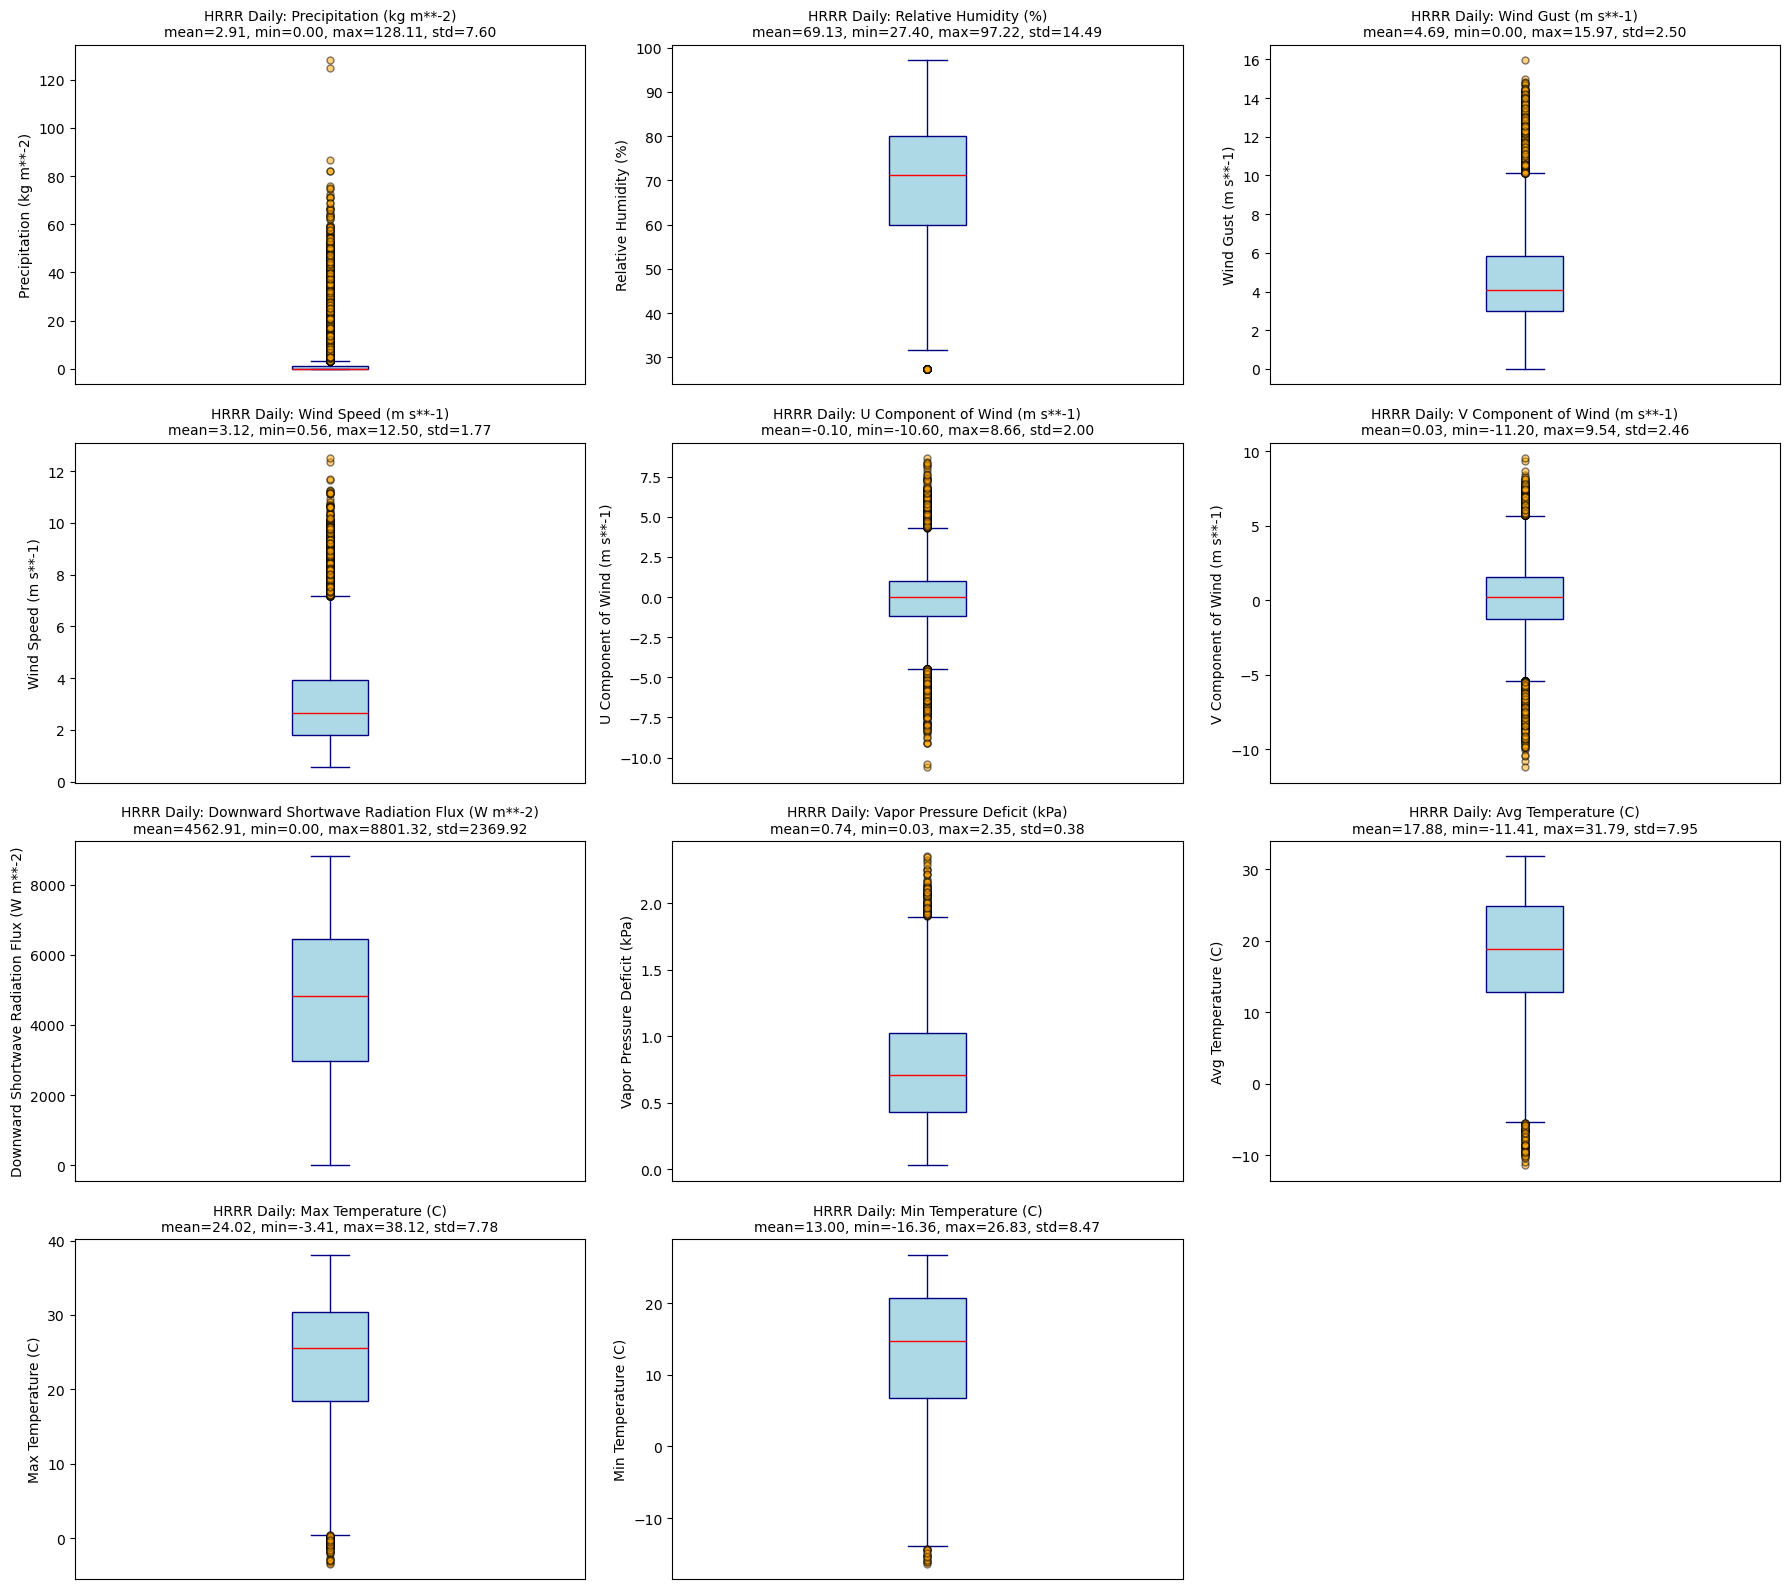

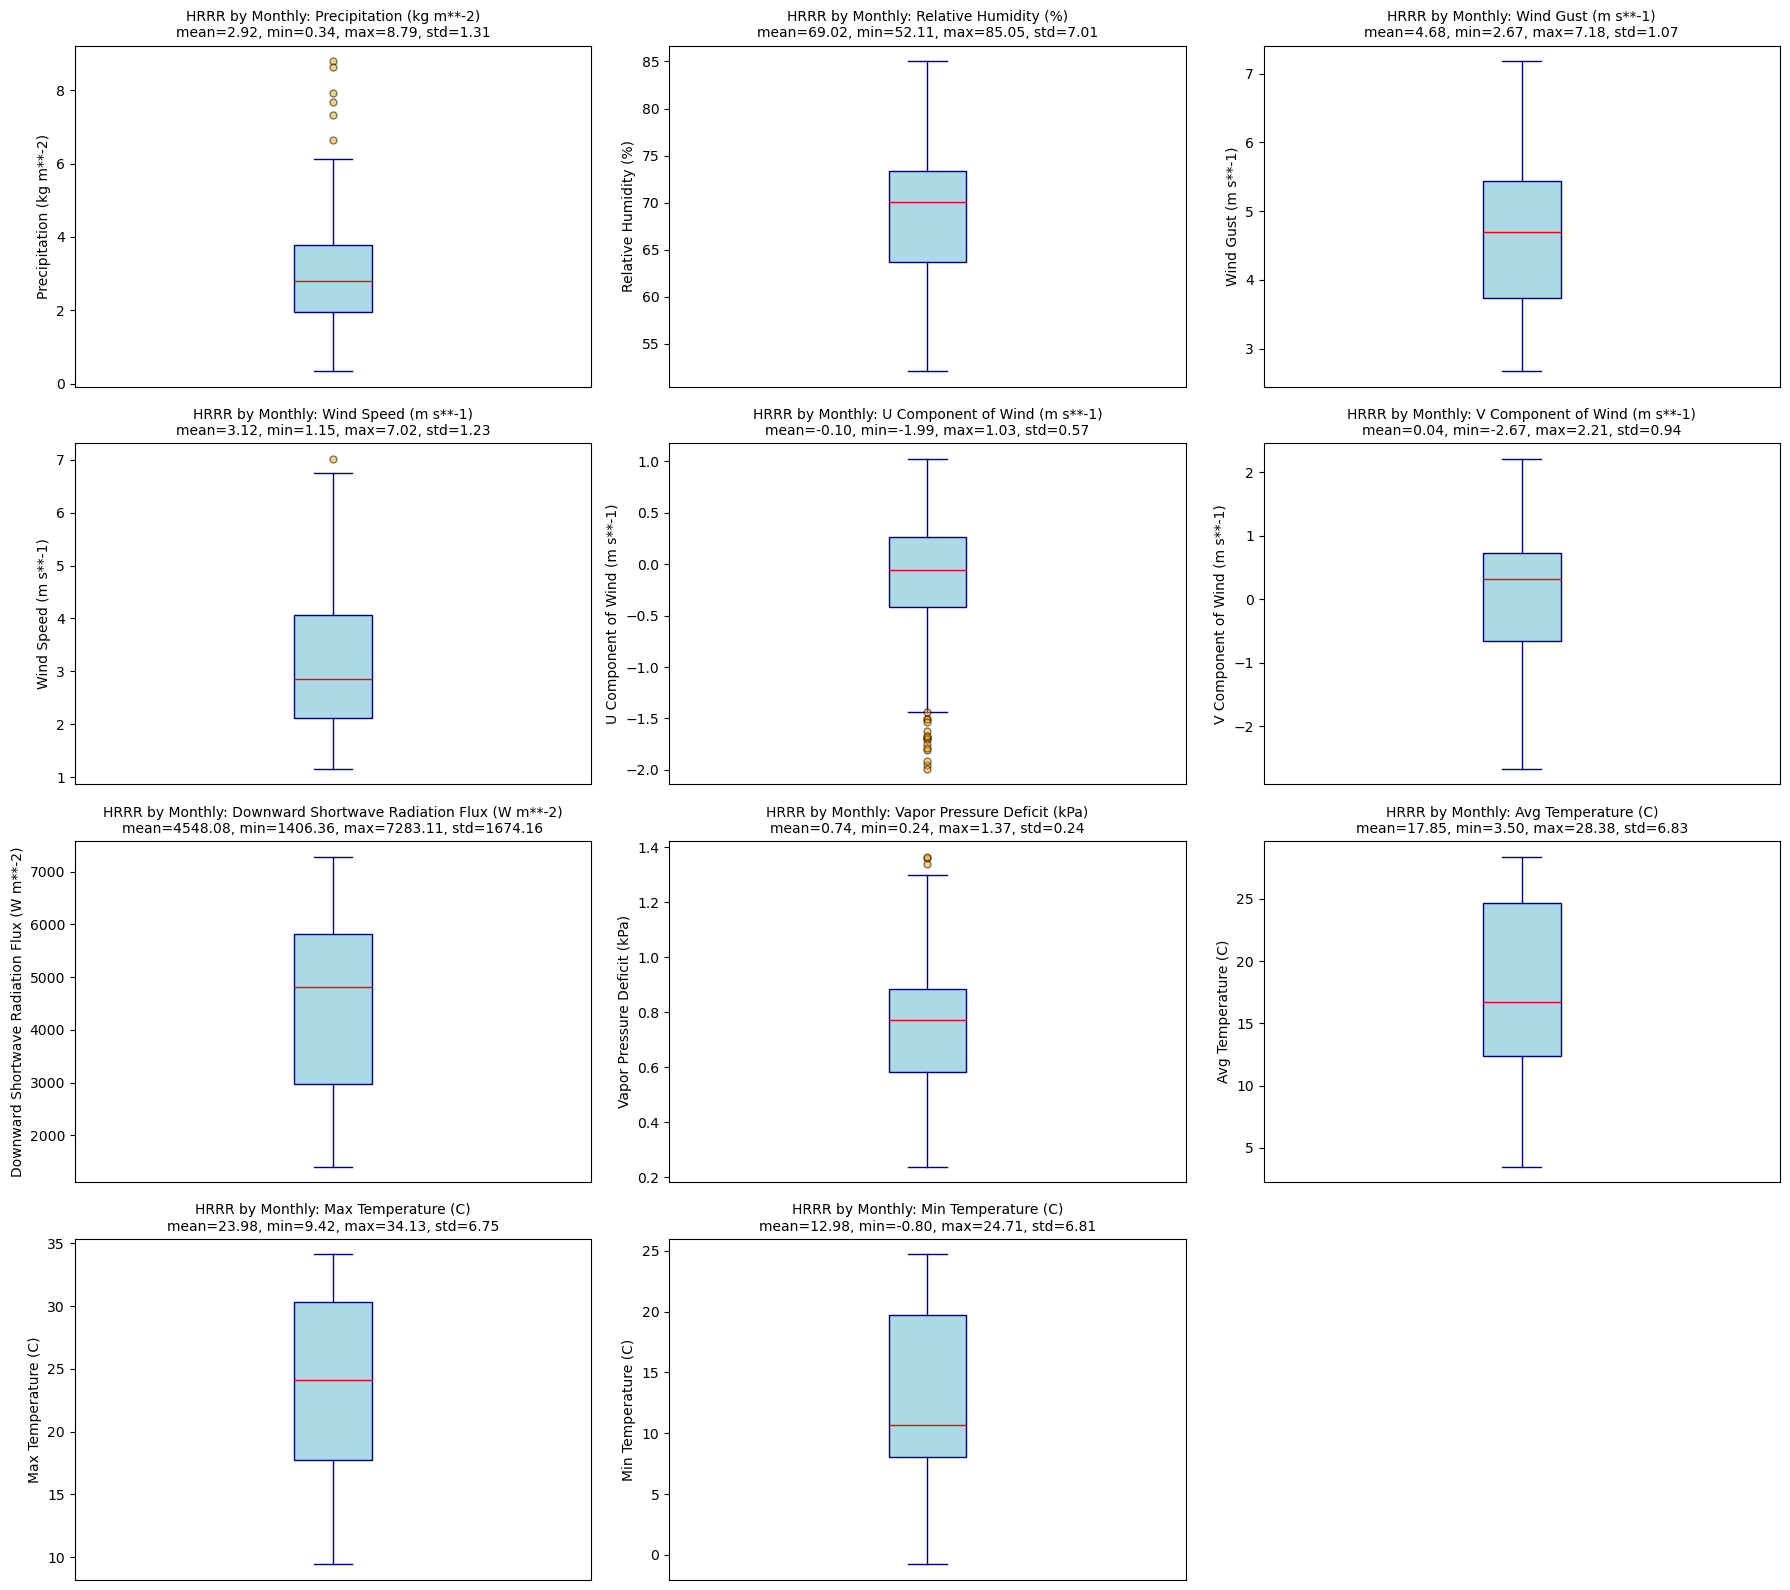

In [18]:
import matplotlib.pyplot as plt
import numpy as np

cols_to_plot = ['Precipitation (kg m**-2)', 'Relative Humidity (%)', 'Wind Gust (m s**-1)', 'Wind Speed (m s**-1)', 'U Component of Wind (m s**-1)', 'V Component of Wind (m s**-1)', 'Downward Shortwave Radiation Flux (W m**-2)', 'Vapor Pressure Deficit (kPa)', 'Avg Temperature (C)', 'Max Temperature (C)', 'Min Temperature (C)']
def plot_boxplots_stats(df, title_prefix):
    n_cols = 3
    n_rows = int(np.ceil(len(cols_to_plot) / n_cols))
    plt.figure(figsize=(n_cols * 6, n_rows * 4))
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot(n_rows, n_cols, i)
        data = df[col].dropna()
        plt.boxplot(data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='navy'),
                    medianprops=dict(color='red'),
                    whiskerprops=dict(color='navy'),
                    capprops=dict(color='navy'),
                    flierprops=dict(markerfacecolor='orange', marker='o', markersize=5, alpha=0.5))
        stats = f"mean={data.mean():.2f}, min={data.min():.2f}, max={data.max():.2f}, std={data.std():.2f}"
        plt.title(f"{title_prefix}: {col}\n{stats}", fontsize=10)
        plt.ylabel(col)
        plt.xticks([])
    plt.tight_layout()
    plt.show()

plot_boxplots_stats(hrrr_all_year_df, "HRRR Daily")
plot_boxplots_stats(hrrr_every_month_df, "HRRR by Monthly")

          Date      County  Max Temperature (C)
0   2022-01-01     LOWNDES            28.021850
1   2022-01-02        DALE            26.194083
2   2022-01-03     HOUSTON            19.953833
3   2022-01-04     RUSSELL            14.176400
4   2022-01-05      GENEVA            18.294429
..         ...         ...                  ...
360 2022-12-27  WASHINGTON            14.792172
361 2022-12-28     CHOCTAW            18.910462
362 2022-12-29      WILCOX            23.778129
363 2022-12-30     HOUSTON            23.198833
364 2022-12-31     HOUSTON            22.626167

[365 rows x 3 columns]


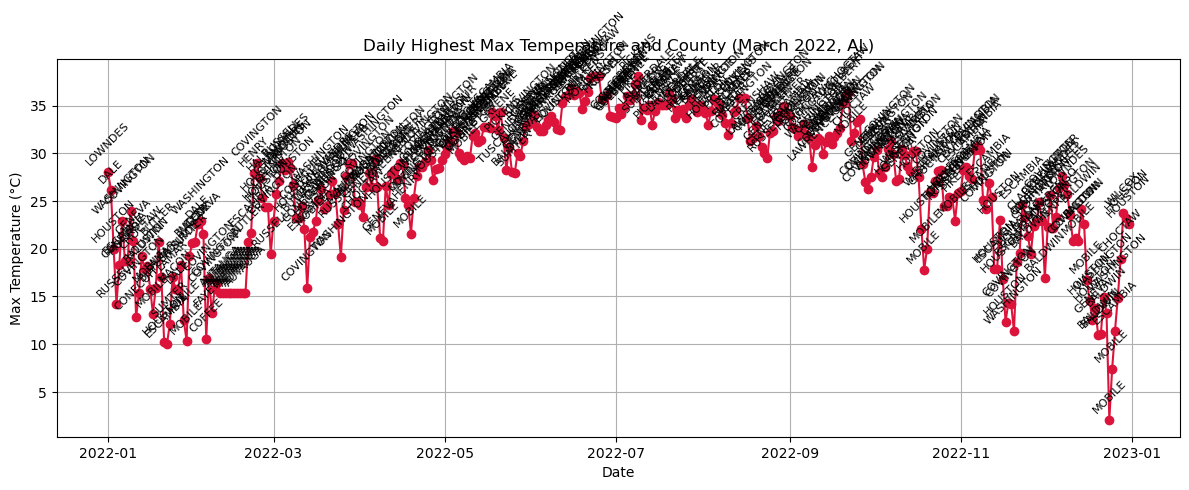

          Date      County  Precipitation (kg m**-2)
0   2022-01-01  LAUDERDALE                 17.014950
1   2022-01-02      MORGAN                 41.730933
2   2022-01-03      DEKALB                 23.318034
3   2022-01-04  TUSCALOOSA                  0.001238
4   2022-01-05     HOUSTON                  0.008417
..         ...         ...                       ...
360 2022-12-27     JACKSON                  0.100629
361 2022-12-28     BALDWIN                  0.021426
362 2022-12-29  LAUDERDALE                  0.157600
363 2022-12-30      MOBILE                 34.111467
364 2022-12-31      GENEVA                 14.530714

[365 rows x 3 columns]


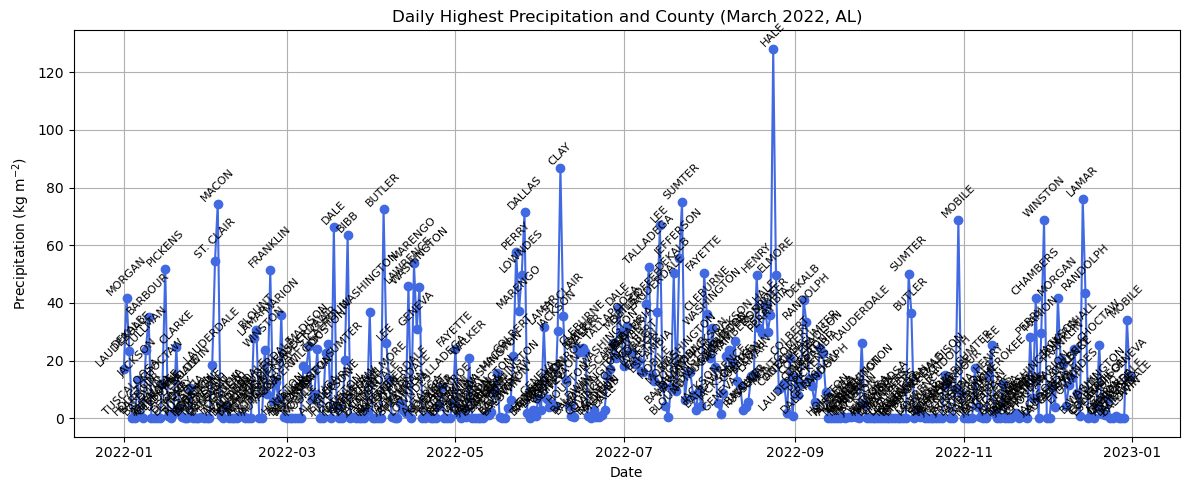

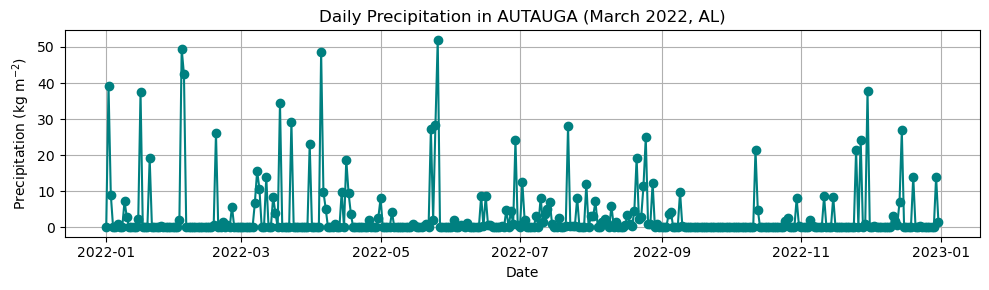

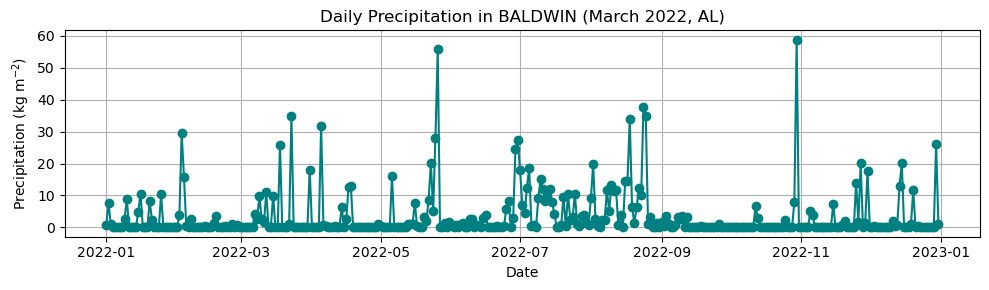

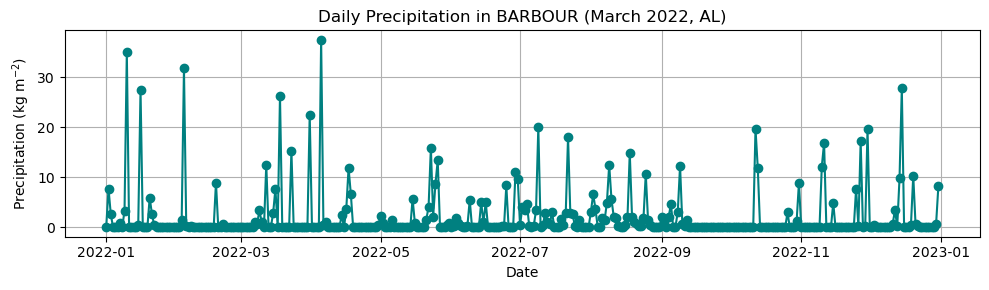

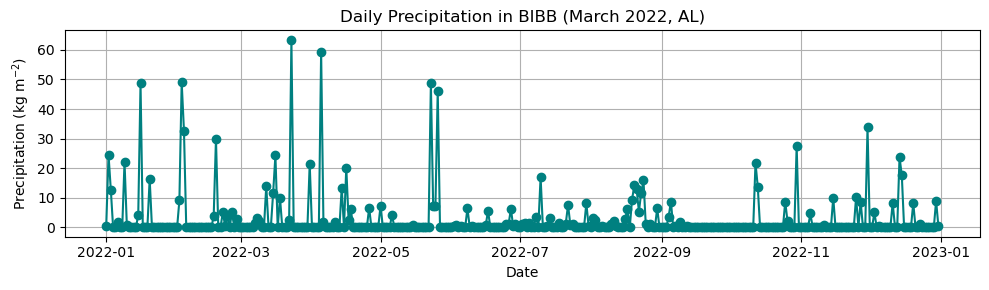

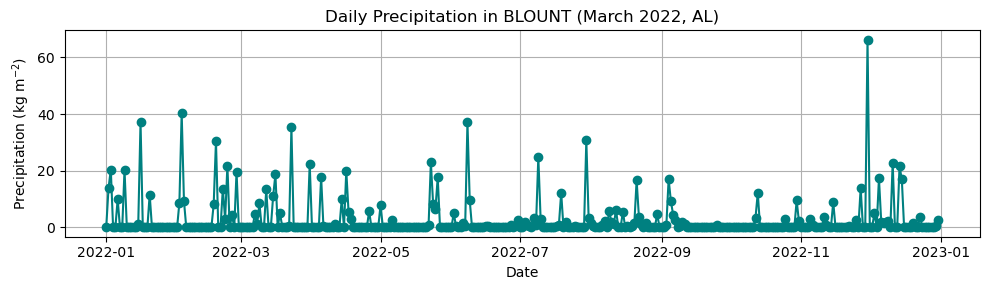

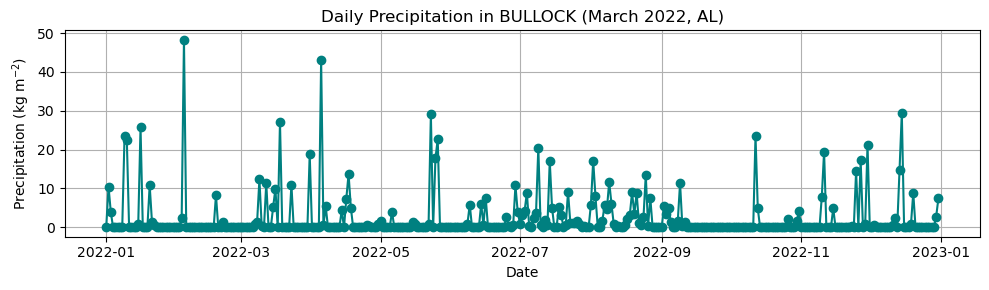

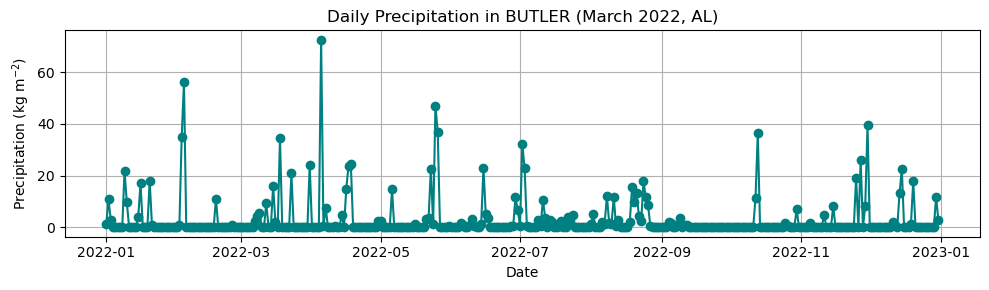

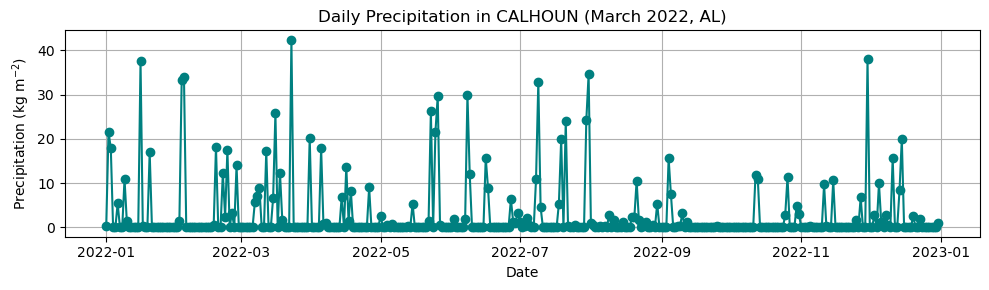

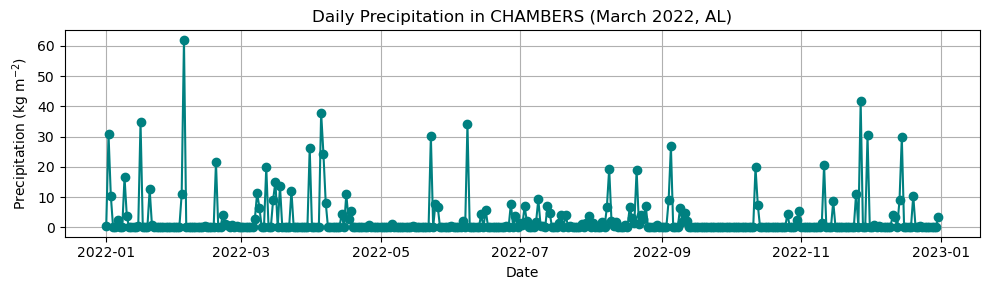

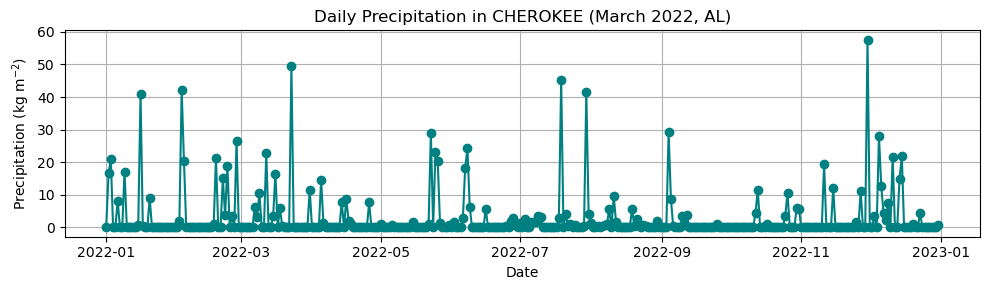

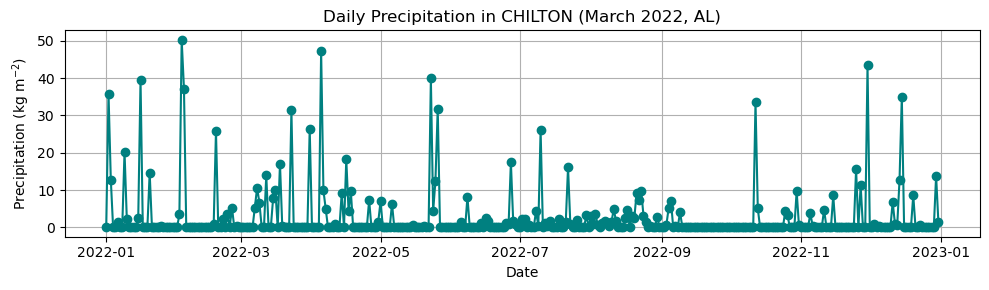

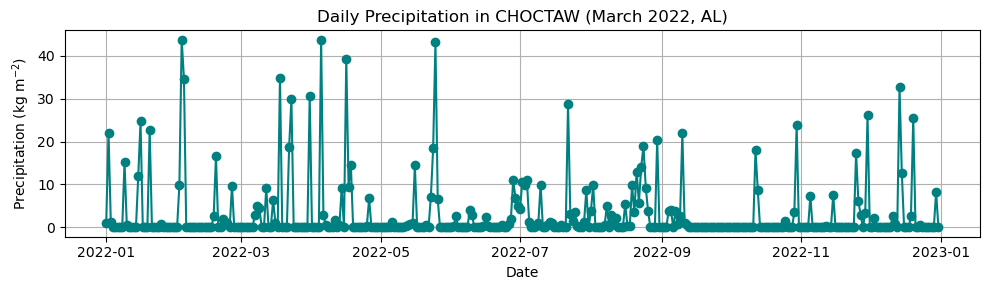

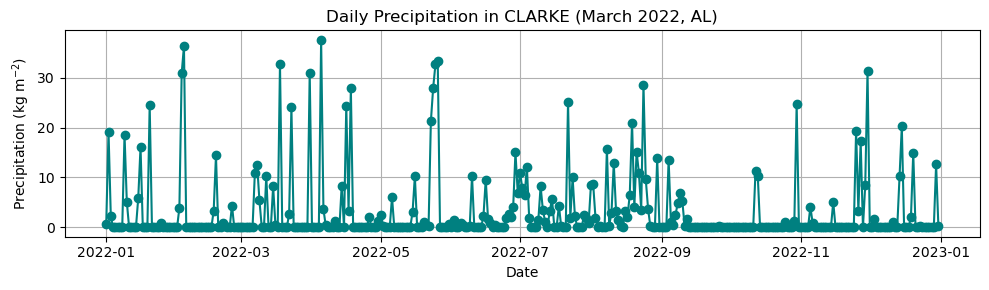

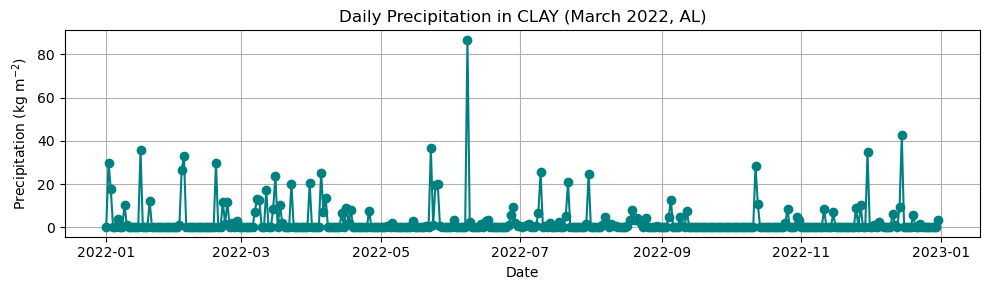

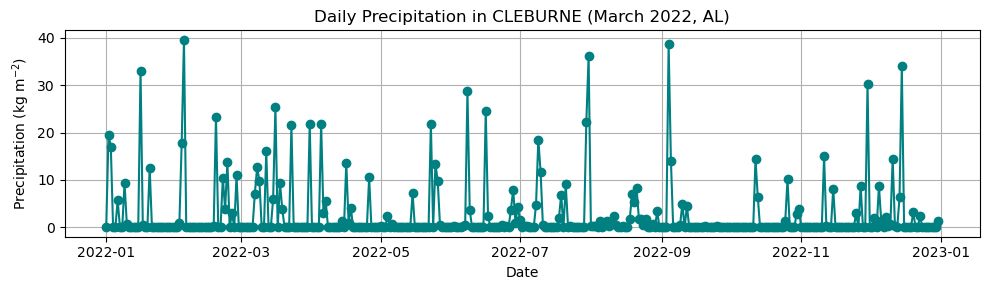

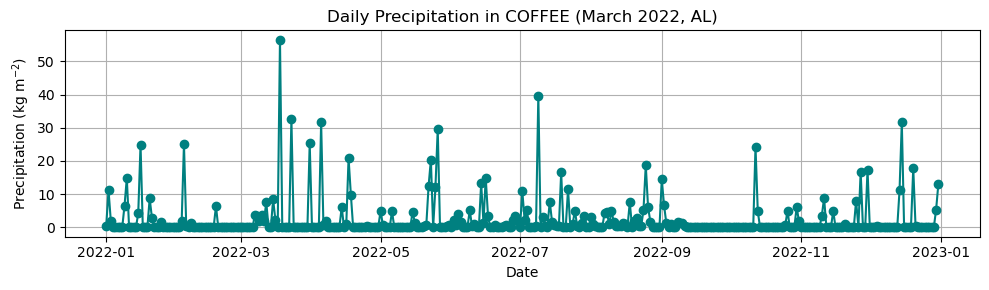

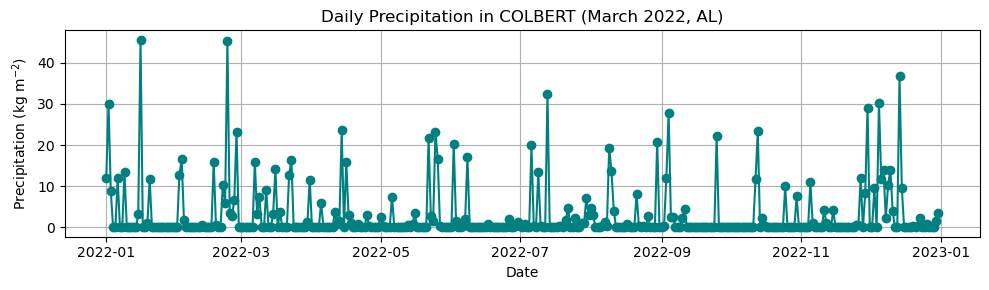

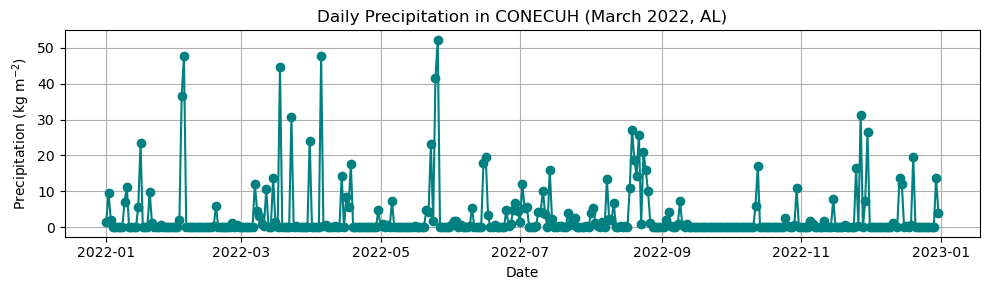

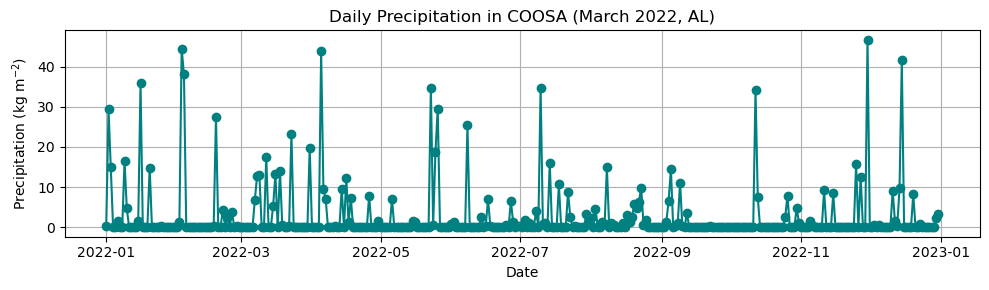

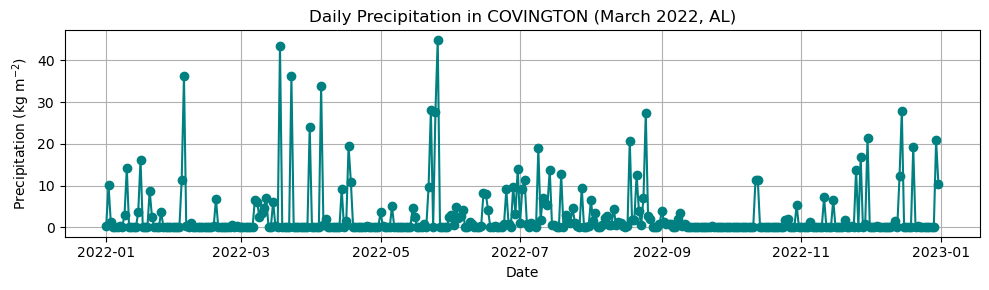

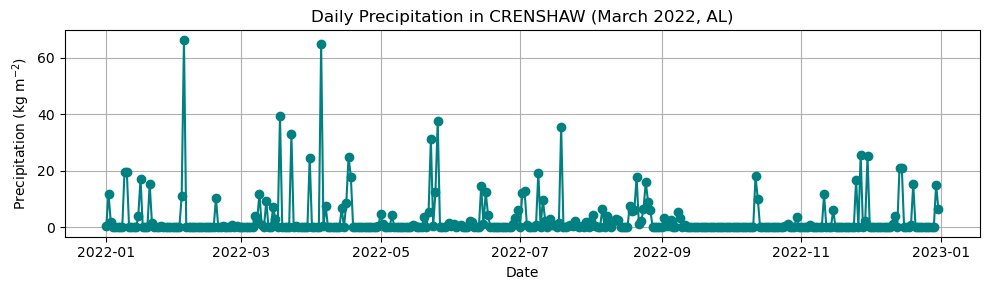

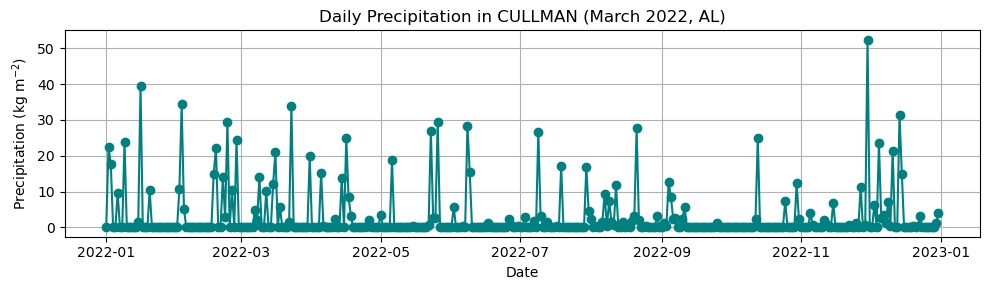

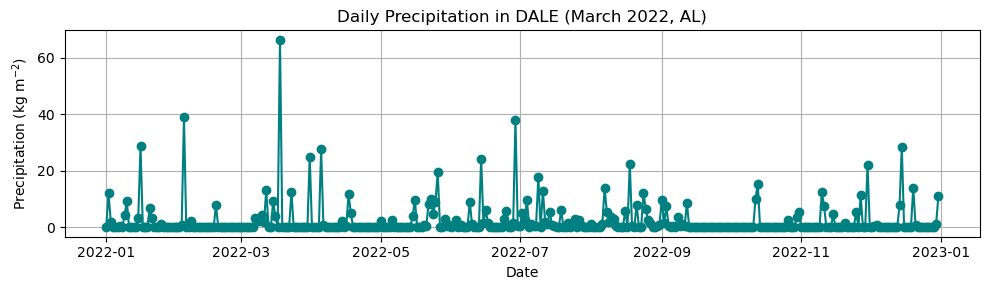

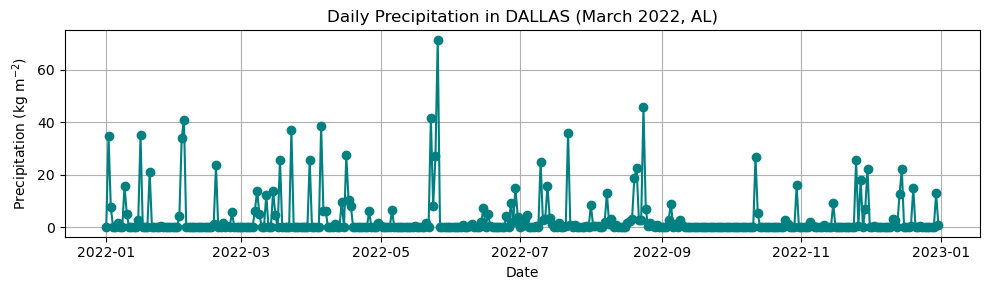

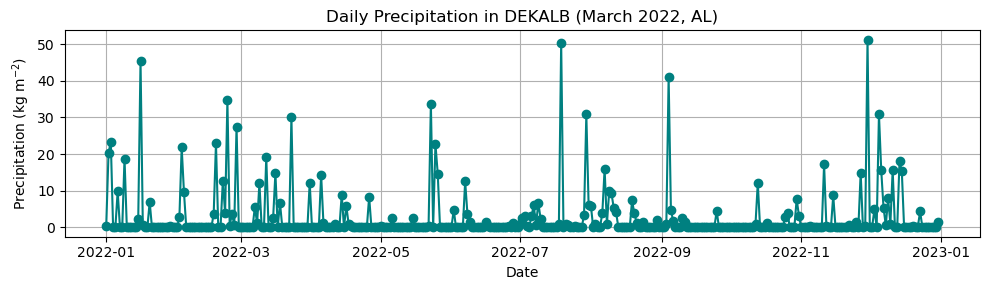

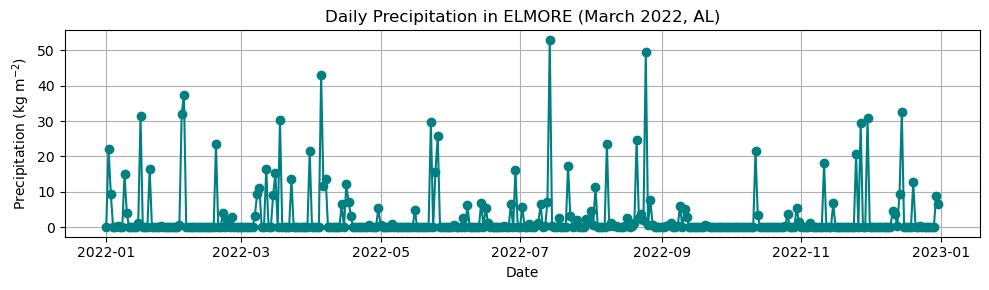

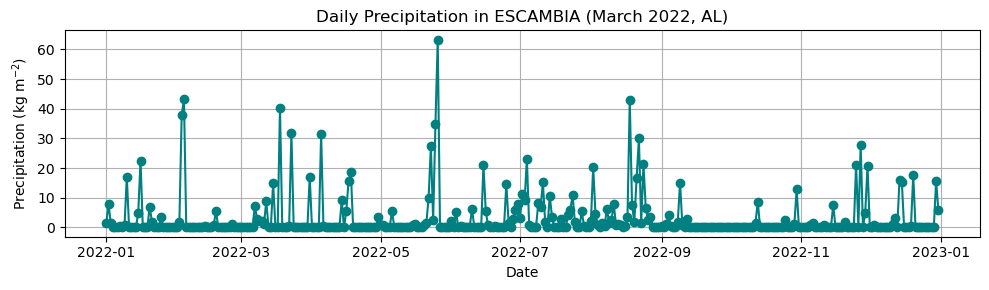

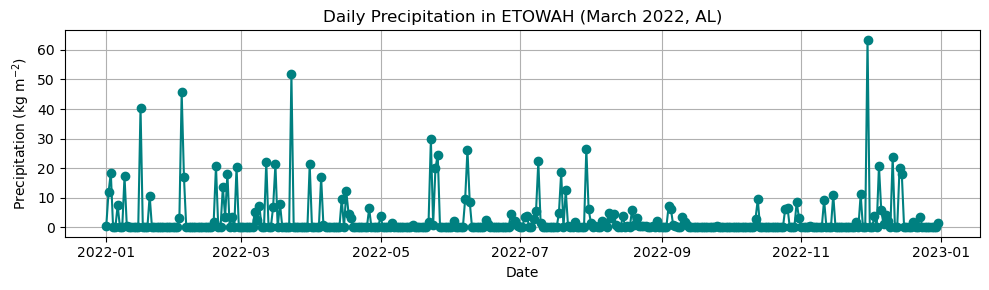

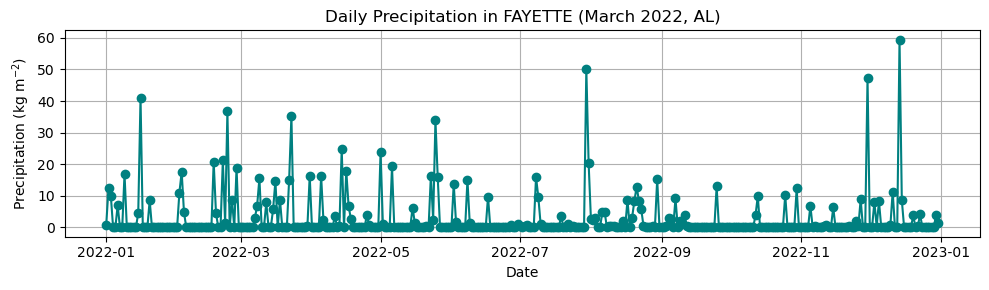

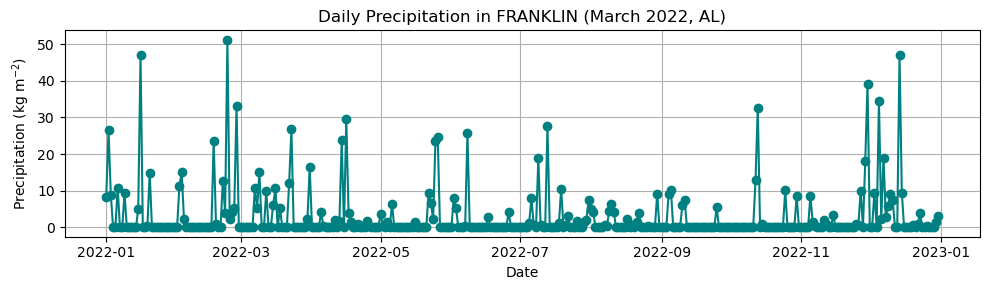

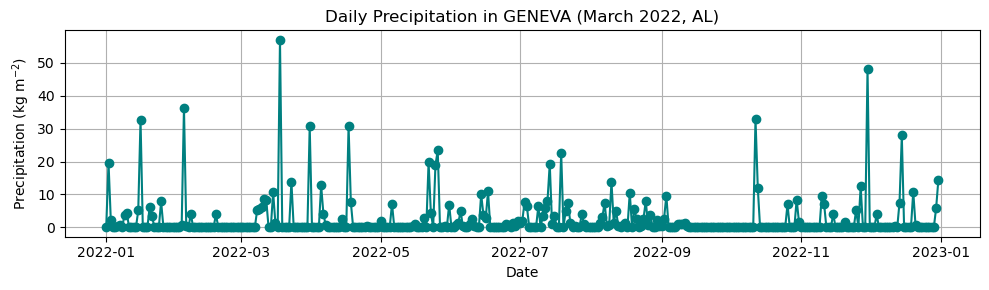

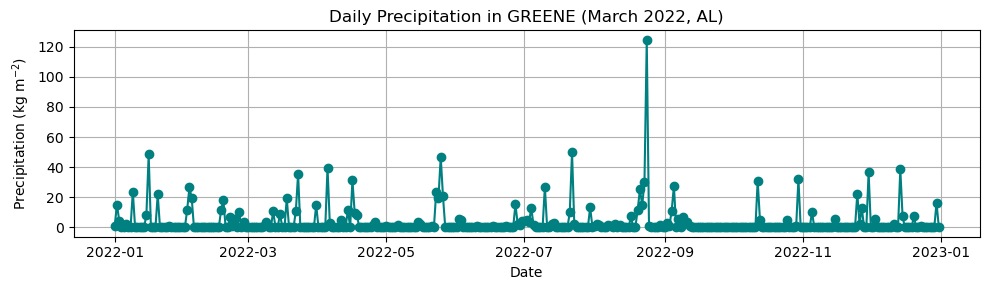

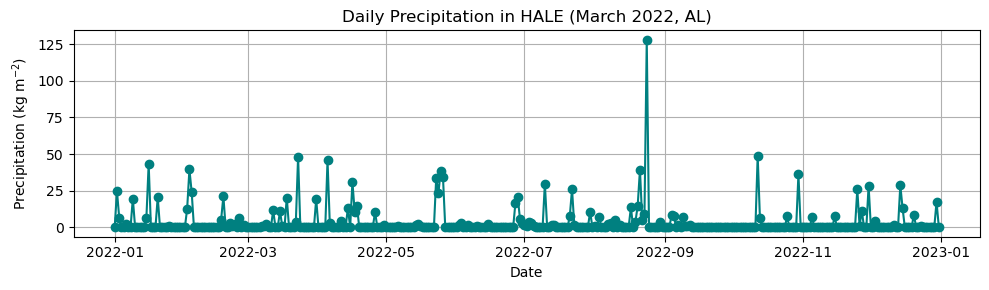

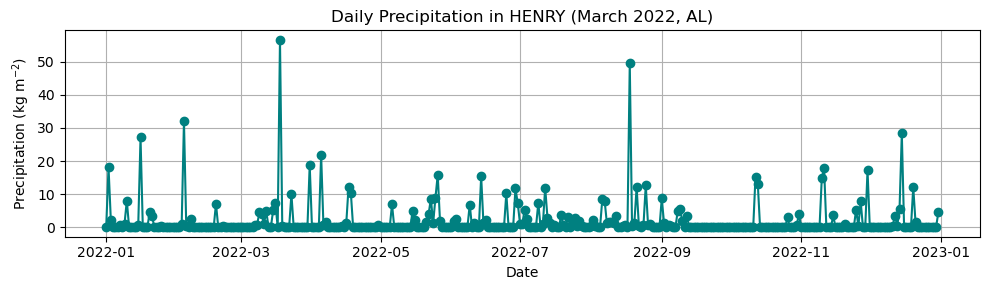

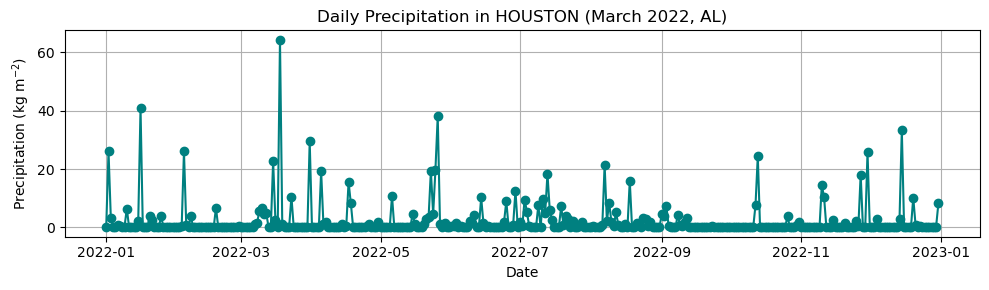

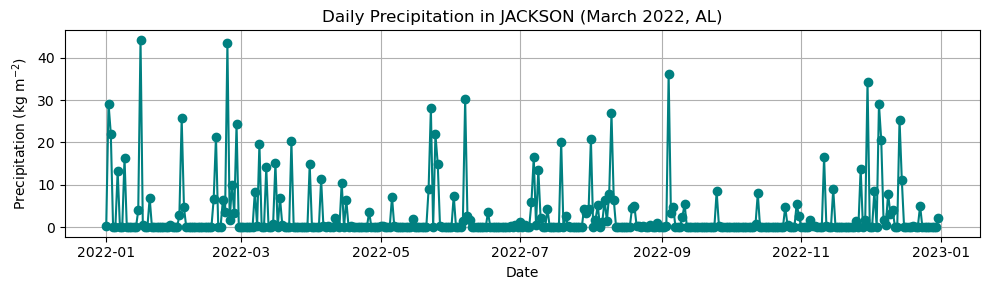

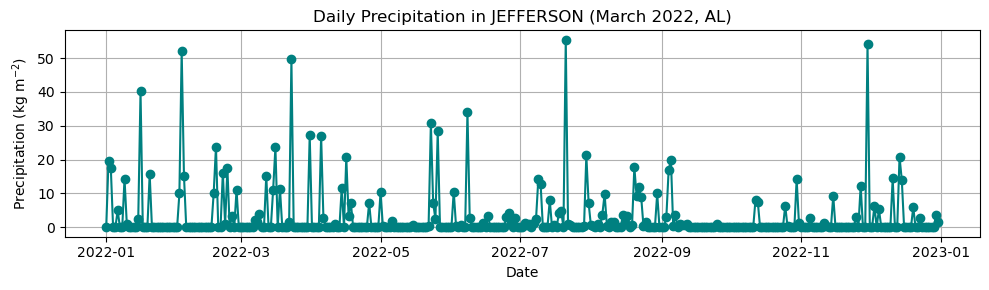

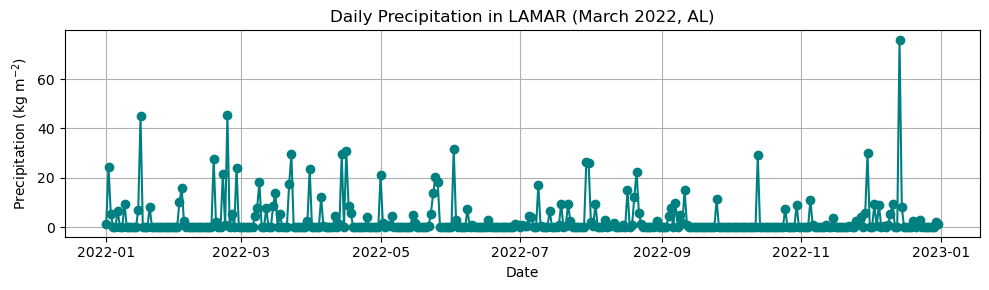

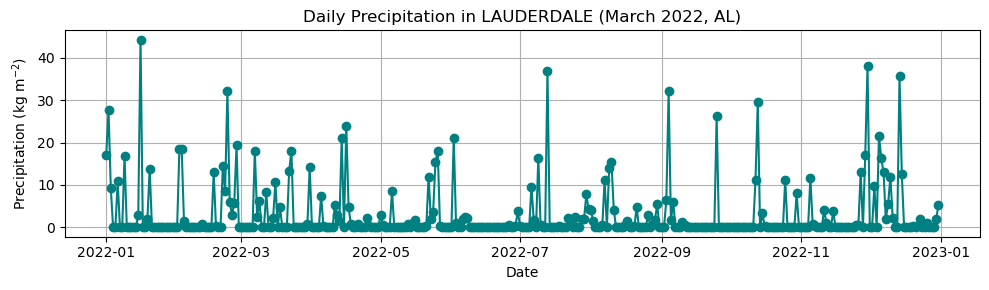

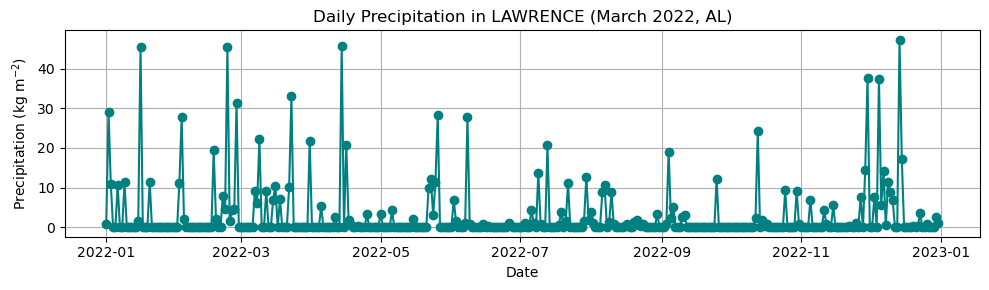

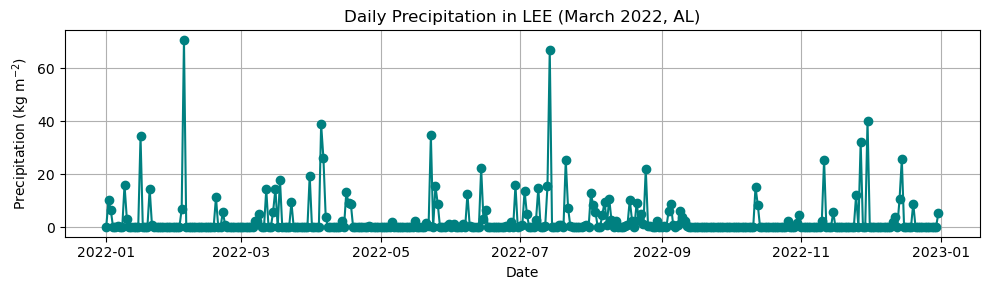

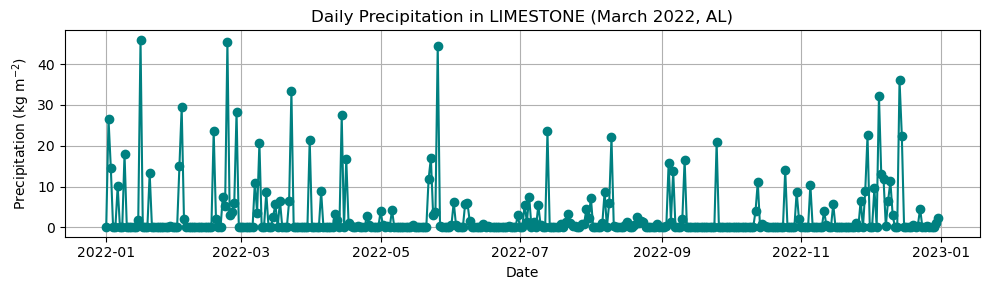

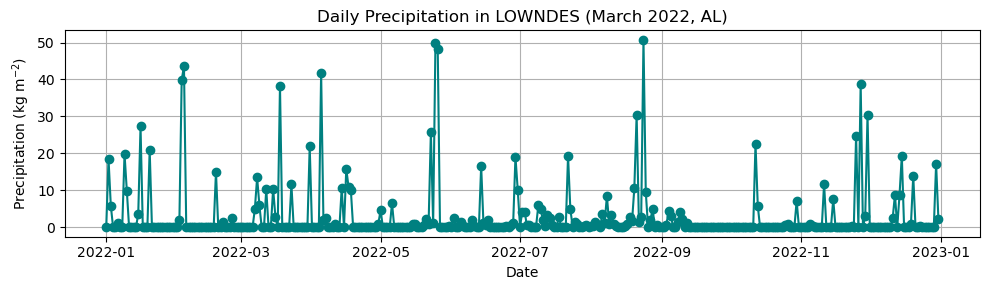

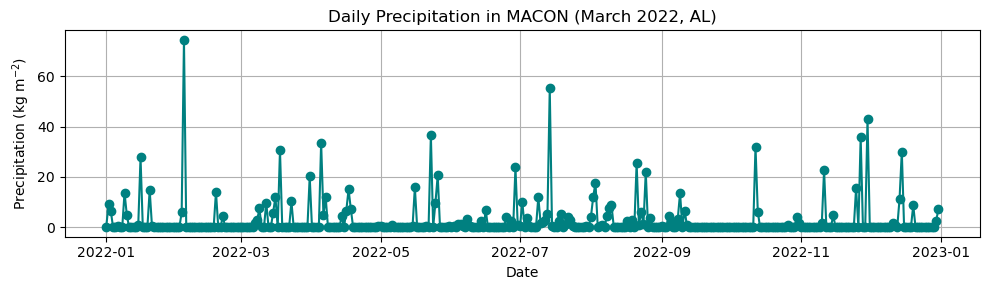

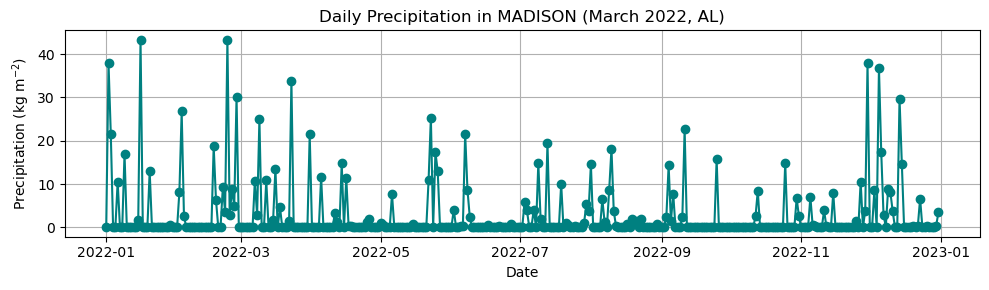

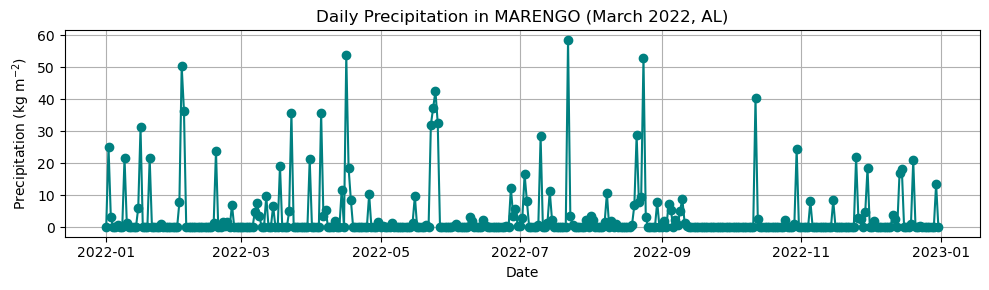

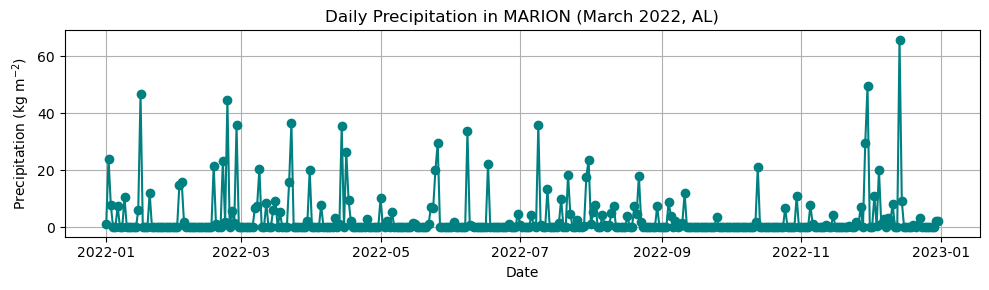

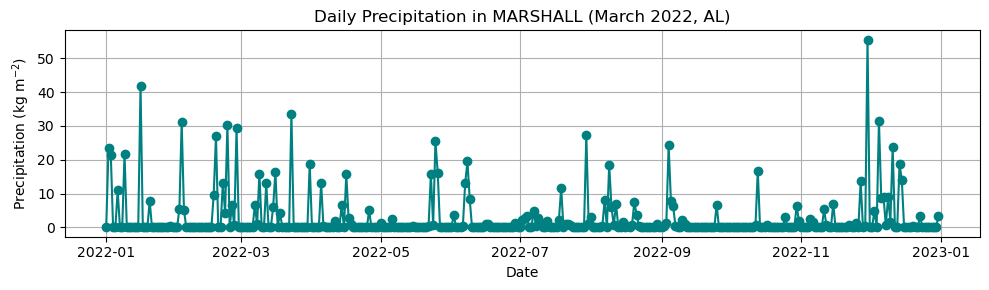

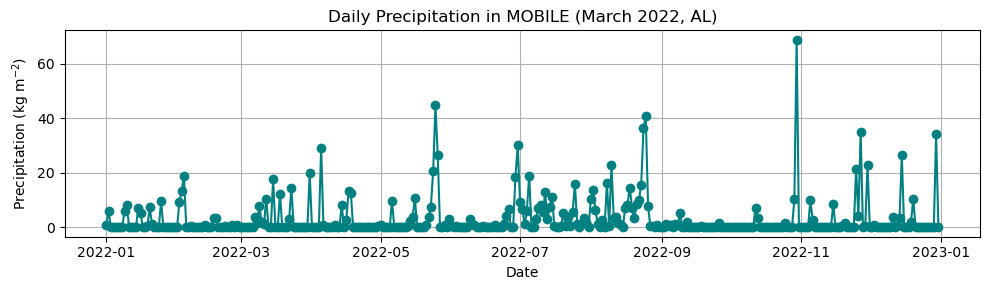

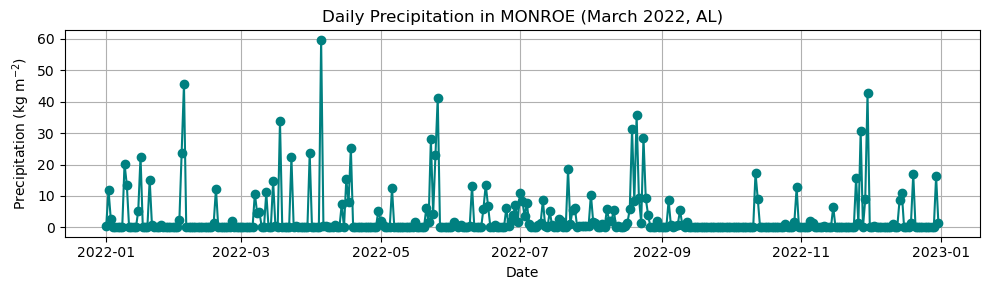

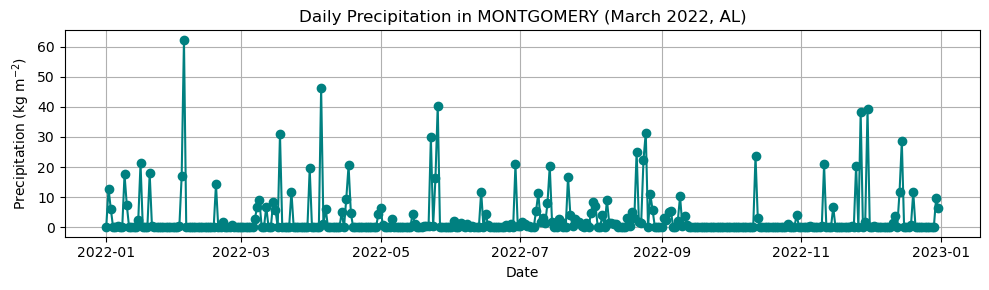

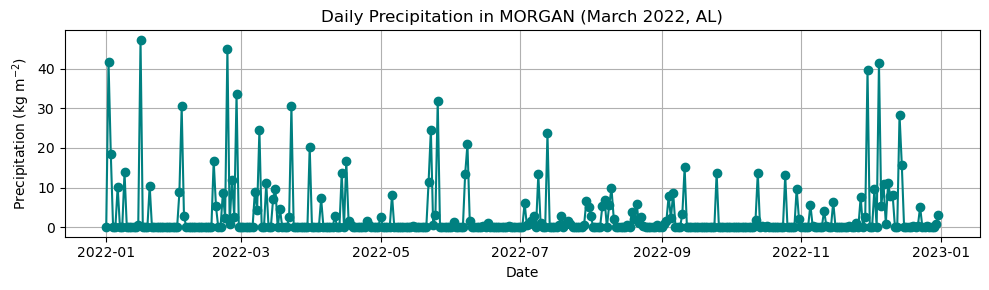

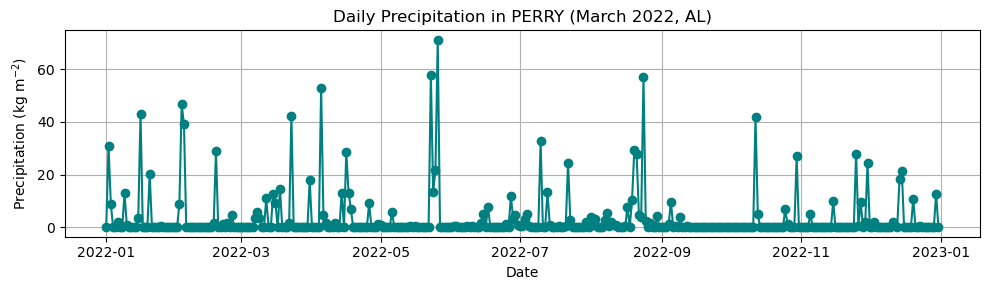

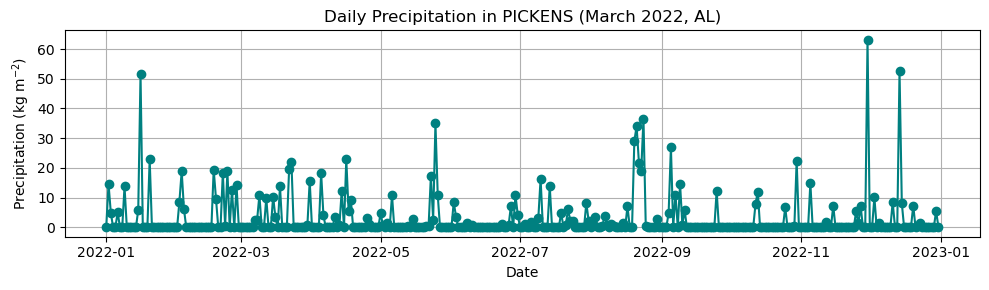

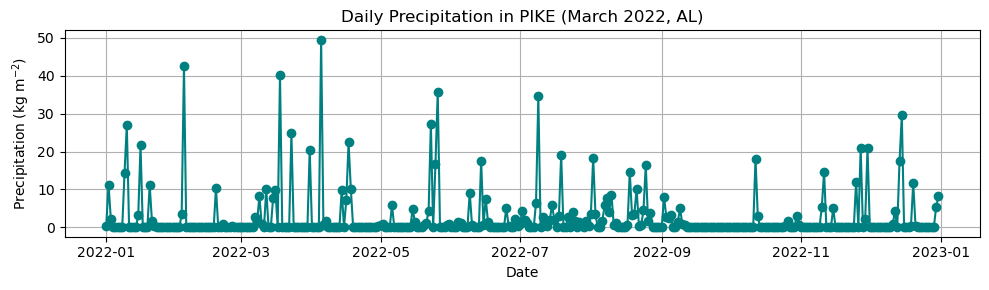

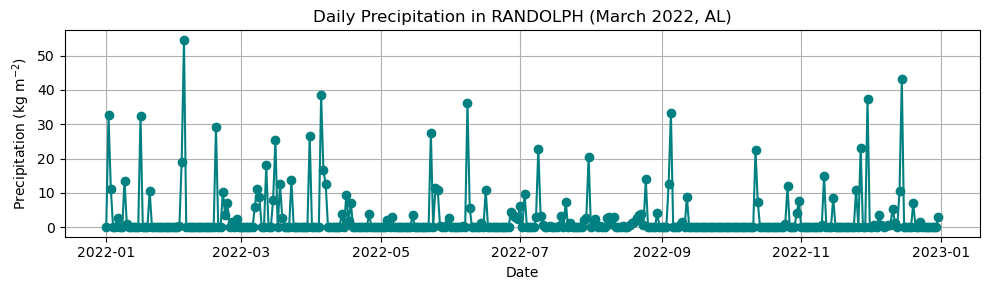

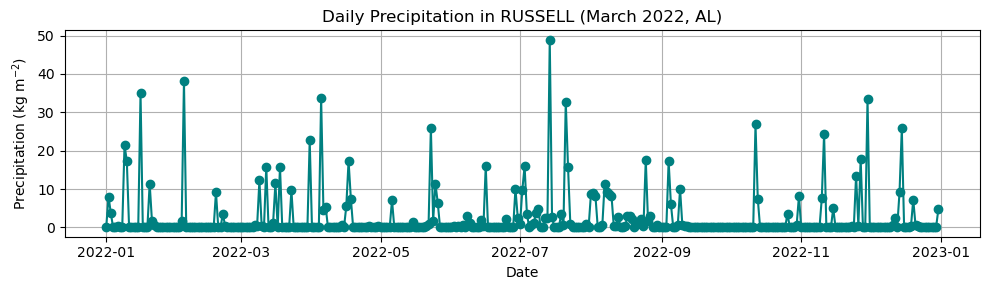

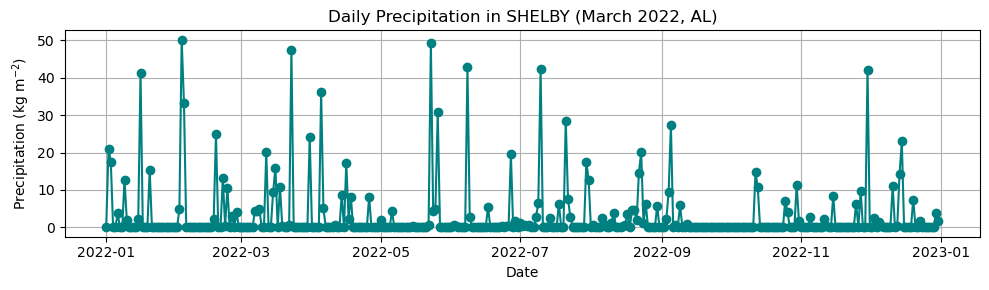

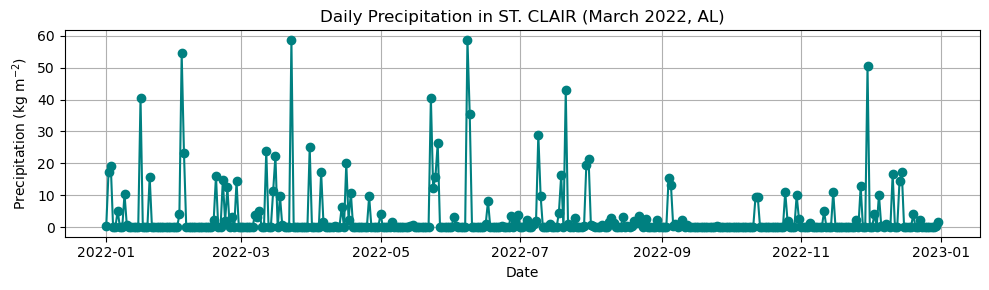

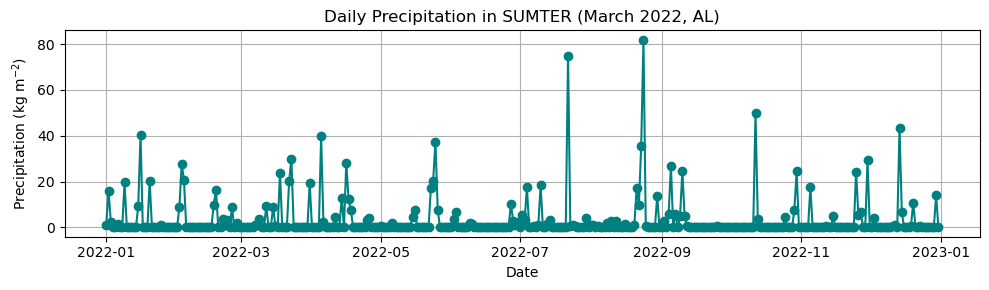

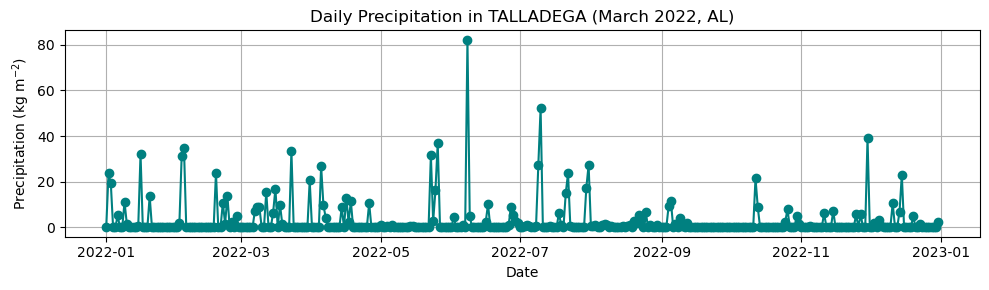

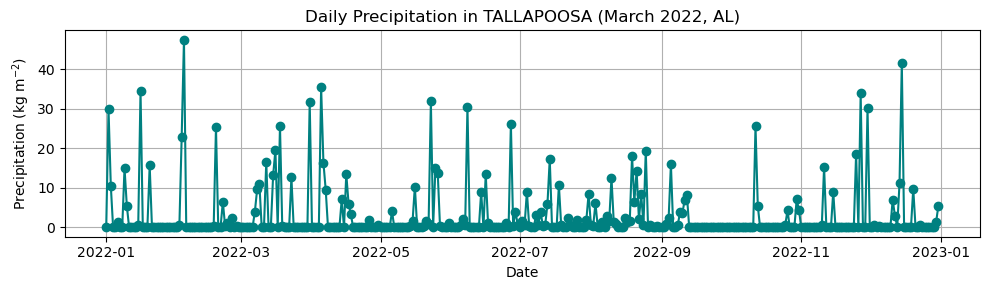

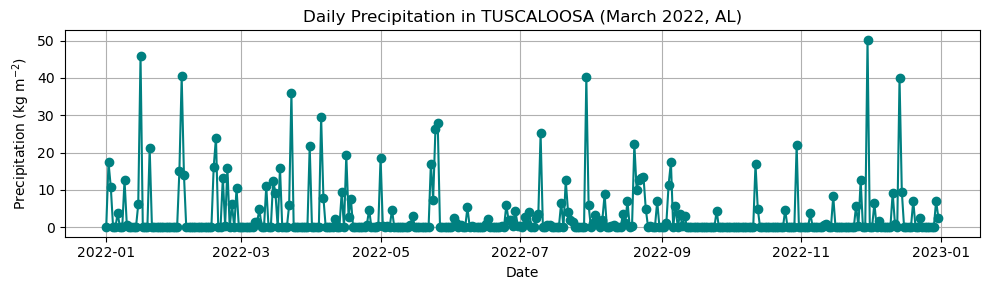

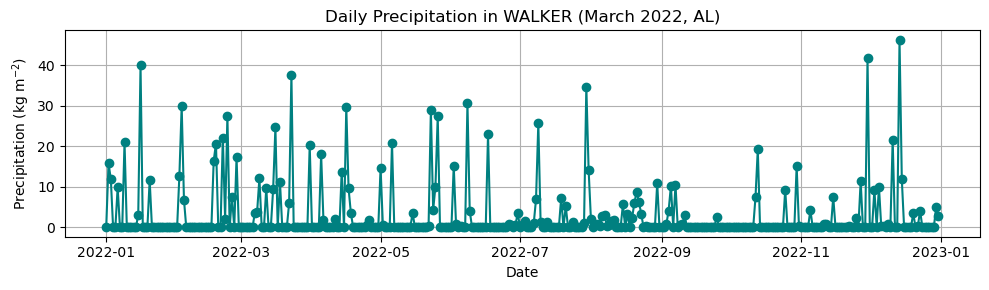

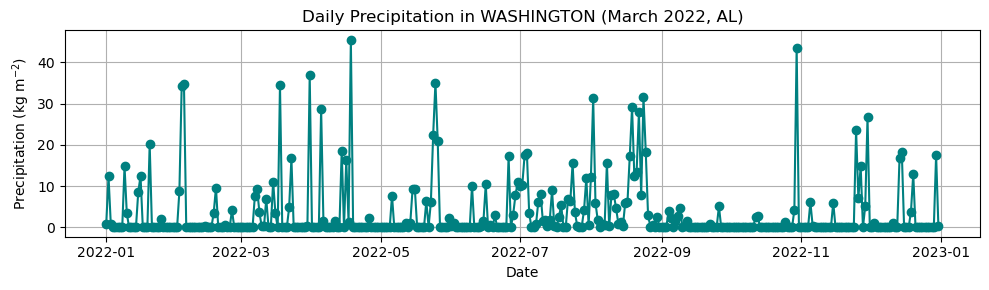

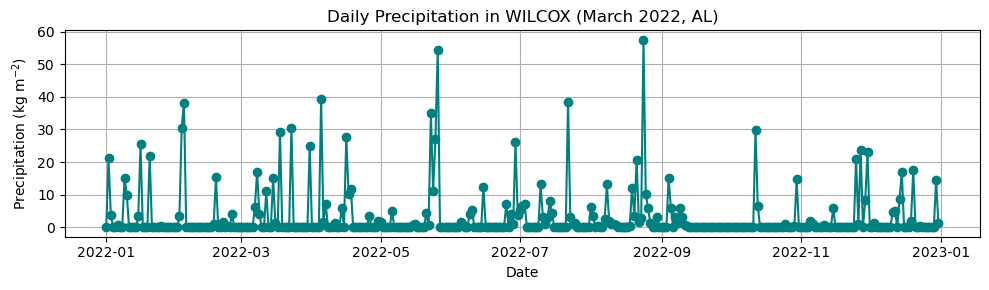

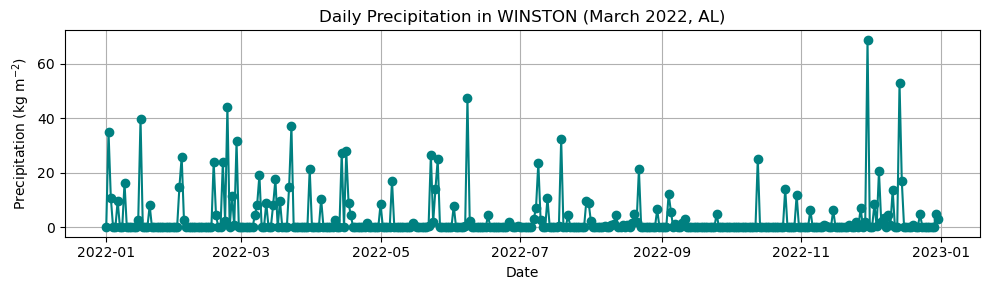

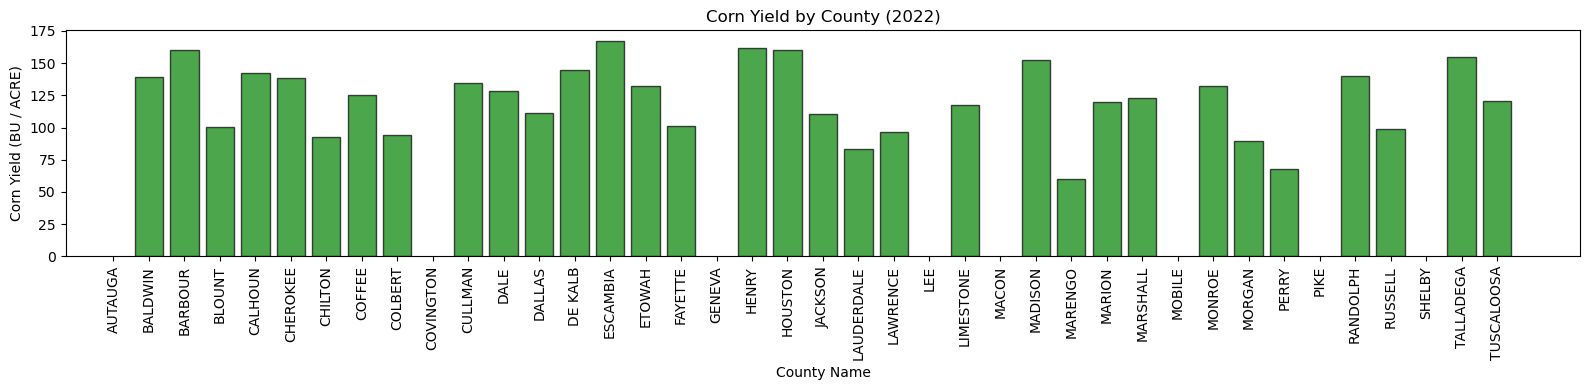

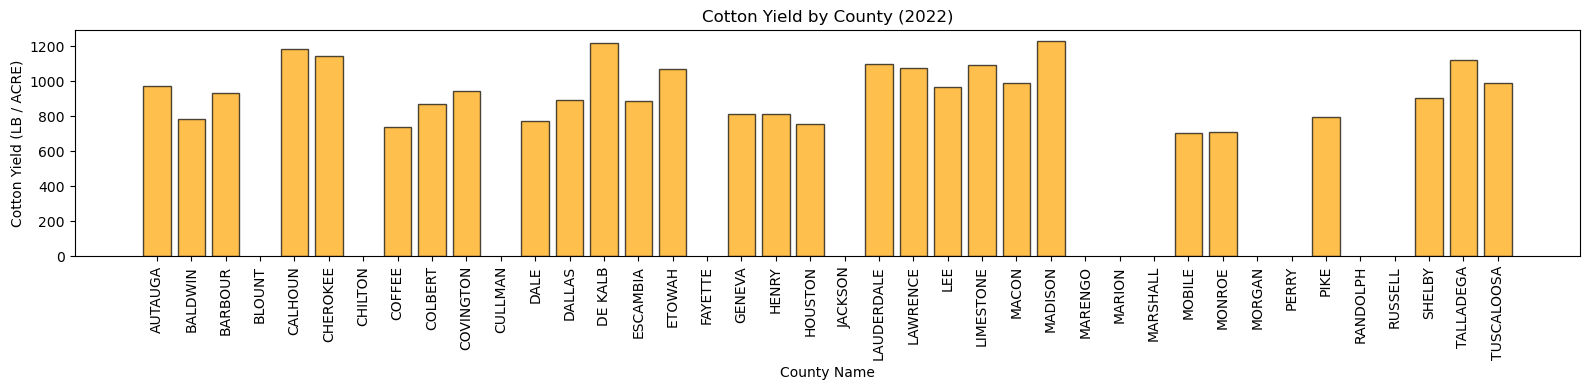

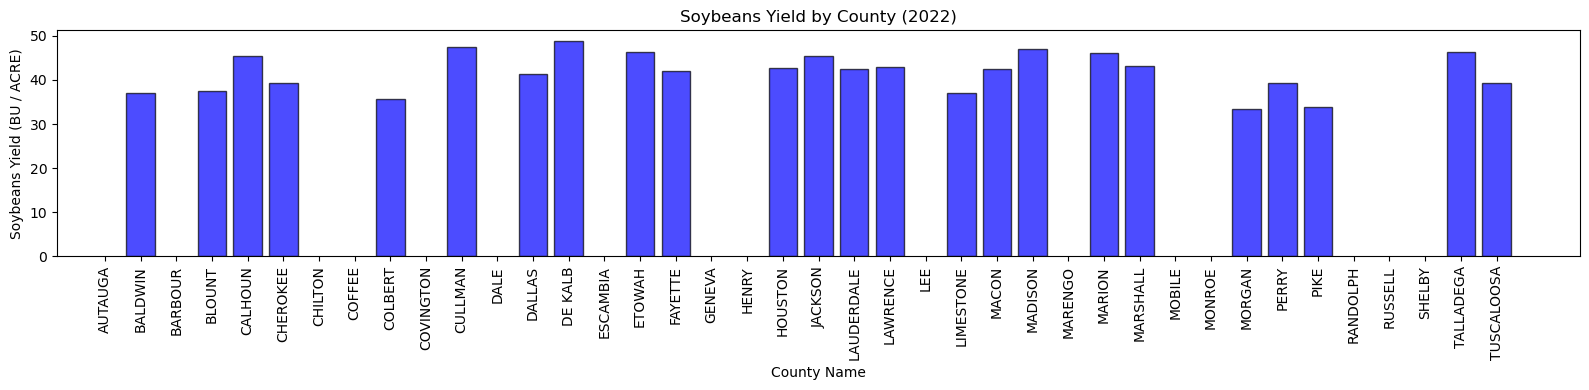

In [19]:

# For each day, find the highest max temperature and the county (and associated grid index) it came from
idx = hrrr_all_year_df.groupby("Date")["Max Temperature (C)"].idxmax()
daily_max_temp = hrrr_all_year_df.loc[idx][["Date", "County", "Max Temperature (C)"]]
daily_max_temp = daily_max_temp.sort_values("Date").reset_index(drop=True)
print(daily_max_temp)

# Line chart: highest max temperature per day and the county it came from
plt.figure(figsize=(12, 5))
plt.plot(daily_max_temp["Date"], daily_max_temp["Max Temperature (C)"], marker='o', linestyle='-', color='crimson', label='Max Temp')
for i, row in daily_max_temp.iterrows():
    plt.text(row["Date"], row["Max Temperature (C)"] + 0.5, row["County"], fontsize=8, rotation=45, ha='center', va='bottom')
plt.title("Daily Highest Max Temperature and County (March 2022, AL)")
plt.xlabel("Date")
plt.ylabel("Max Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

# For each day, find the highest precipitation and the county (and associated grid index) it came from
idx = hrrr_all_year_df.groupby("Date")["Precipitation (kg m**-2)"].idxmax()
daily_max_precip = hrrr_all_year_df.loc[idx][["Date", "County", "Precipitation (kg m**-2)"]]
daily_max_precip = daily_max_precip.sort_values("Date").reset_index(drop=True)
print(daily_max_precip)

# Line chart: highest precipitation per day and the county it came from
plt.figure(figsize=(12, 5))
plt.plot(daily_max_precip["Date"], daily_max_precip["Precipitation (kg m**-2)"], marker='o', linestyle='-', color='royalblue', label='Max Precipitation')
for i, row in daily_max_precip.iterrows():
    plt.text(row["Date"], row["Precipitation (kg m**-2)"] + 0.2, row["County"], fontsize=8, rotation=45, ha='center', va='bottom')
plt.title("Daily Highest Precipitation and County (March 2022, AL)")
plt.xlabel("Date")
plt.ylabel("Precipitation (kg m$^{-2}$)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 67 graphs: daily precipitation for each county
unique_counties = hrrr_all_year_df["County"].unique()
for county in unique_counties:
    county_df = hrrr_all_year_df[hrrr_all_year_df["County"] == county]
    plt.figure(figsize=(10, 3))
    plt.plot(county_df["Date"], county_df["Precipitation (kg m**-2)"], marker='o', linestyle='-', color='teal')
    plt.title(f"Daily Precipitation in {county} (March 2022, AL)")
    plt.xlabel("Date")
    plt.ylabel("Precipitation (kg m$^{-2}$)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Distribution of crop yield across counties (bar chart)
# Bar chart for Corn Yield
plt.figure(figsize=(16, 4))
plt.bar(usda_all_crops_grouped["county_name"], usda_all_crops_grouped["Corn_Yield_BU_ACRE"], color='green', edgecolor='black', alpha=0.7)
plt.title("Corn Yield by County (2022)")
plt.xlabel("County Name")
plt.ylabel("Corn Yield (BU / ACRE)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Bar chart for Cotton Yield
plt.figure(figsize=(16, 4))
plt.bar(usda_all_crops_grouped["county_name"], usda_all_crops_grouped["Cotton_Yield_LB_ACRE"], color='orange', edgecolor='black', alpha=0.7)
plt.title("Cotton Yield by County (2022)")
plt.xlabel("County Name")
plt.ylabel("Cotton Yield (LB / ACRE)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Bar chart for Soybeans Yield
plt.figure(figsize=(16, 4))
plt.bar(usda_all_crops_grouped["county_name"], usda_all_crops_grouped["Soybeans_Yield_BU_ACRE"], color='blue', edgecolor='black', alpha=0.7)
plt.title("Soybeans Yield by County (2022)")
plt.xlabel("County Name")
plt.ylabel("Soybeans Yield (BU / ACRE)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Bar chart for Winter Wheat Yield (if any data)
if usda_all_crops_grouped["WinterWheat_Yield_BU_ACRE"].notna().sum() > 0:
    plt.figure(figsize=(16, 4))
    plt.bar(usda_all_crops_grouped["county_name"], usda_all_crops_grouped["WinterWheat_Yield_BU_ACRE"], color='purple', edgecolor='black', alpha=0.7)
    plt.title("Winter Wheat Yield by County (2022)")
    plt.xlabel("County Name")
    plt.ylabel("Winter Wheat Yield (BU / ACRE)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

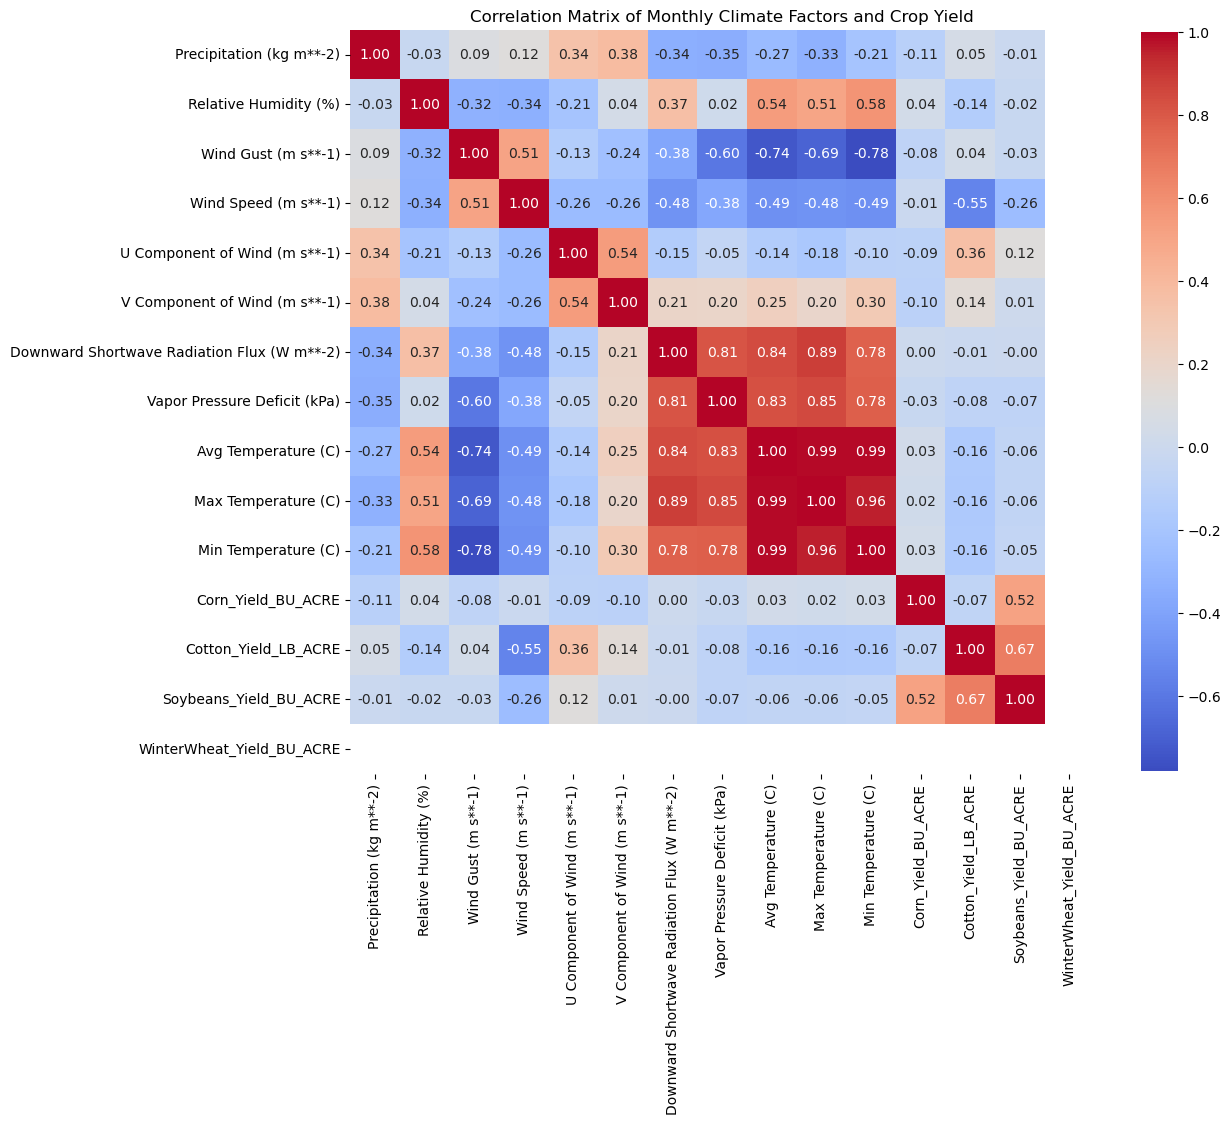


Correlations with Corn_Yield_BU_ACRE:
Corn_Yield_BU_ACRE                             1.000000
Soybeans_Yield_BU_ACRE                         0.519569
Relative Humidity (%)                          0.039977
Min Temperature (C)                            0.033331
Avg Temperature (C)                            0.028543
Max Temperature (C)                            0.021875
Downward Shortwave Radiation Flux (W m**-2)    0.002018
Wind Speed (m s**-1)                          -0.011357
Vapor Pressure Deficit (kPa)                  -0.025397
Cotton_Yield_LB_ACRE                          -0.065036
Wind Gust (m s**-1)                           -0.076483
U Component of Wind (m s**-1)                 -0.090441
V Component of Wind (m s**-1)                 -0.096786
Precipitation (kg m**-2)                      -0.107446
WinterWheat_Yield_BU_ACRE                           NaN
Name: Corn_Yield_BU_ACRE, dtype: float64

Correlations with Cotton_Yield_LB_ACRE:
Cotton_Yield_LB_ACRE                   

In [20]:
import seaborn as sns

# Merge HRRR monthly data with USDA crop yield data by FIPS, keeping all HRRR monthly rows (left join)
merged_monthly_df = hrrr_every_month_df.merge(
    usda_all_crops_grouped[["FIPS", "Corn_Yield_BU_ACRE", "Cotton_Yield_LB_ACRE", "Soybeans_Yield_BU_ACRE", "WinterWheat_Yield_BU_ACRE"]],
    on="FIPS",
    how="left"
)

# Only drop rows where all yield columns are missing (keep rows with at least one yield value)
yield_cols = ["Corn_Yield_BU_ACRE", "Cotton_Yield_LB_ACRE", "Soybeans_Yield_BU_ACRE", "WinterWheat_Yield_BU_ACRE"]
merged_monthly_df_clean = merged_monthly_df.dropna(subset=yield_cols, how="all")

# Only include numeric columns in the correlation matrix
monthly_numeric_df = merged_monthly_df_clean.select_dtypes(include=["number"])

# If there are still no rows, print a warning and skip plotting
if monthly_numeric_df.empty:
    print("No data available for correlation analysis after cleaning. Please check your merge and data availability.")
else:
    # Compute correlation matrix
    monthly_corr_matrix = monthly_numeric_df.corr()

    # Plot heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(monthly_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    plt.title("Correlation Matrix of Monthly Climate Factors and Crop Yield")
    plt.show()

    # Print correlation of all yield columns with other variables (if any correlations exist)
    for ycol in yield_cols:
        if ycol in monthly_corr_matrix.columns:
            print(f"\nCorrelations with {ycol}:")
            try:
                print(monthly_corr_matrix[ycol].sort_values(ascending=False))
            except Exception as e:
                print(f"Could not compute correlations for {ycol}: {e}")

In [21]:
merged_monthly_df_clean

State      County  Precipitation (kg m**-2)  Relative Humidity (%)  \
0    ALABAMA     AUTAUGA                  3.830028              68.428817   
1    ALABAMA     BALDWIN                  1.841861              72.732998   
2    ALABAMA     BARBOUR                  2.799485              66.396344   
4    ALABAMA      BLOUNT                  3.703056              66.927074   
7    ALABAMA     CALHOUN                  3.616523              66.408065   
..       ...         ...                       ...                    ...   
792  ALABAMA    RANDOLPH                  2.551949              72.814247   
793  ALABAMA     RUSSELL                  1.663276              70.803387   
795  ALABAMA      SHELBY                  2.185778              71.305784   
797  ALABAMA   TALLADEGA                  1.814436              70.809010   
799  ALABAMA  TUSCALOOSA                  2.826740              72.746851   

     Wind Gust (m s**-1)  Wind Speed (m s**-1)  U Component of Wind (m s**-1)  \
0               6.175469              4.755189                       0.429174   
1               6.853068              6.743207                       0.354913   
2               5.963249              4.273303                       0.557912   
4               6.529457              3.103699                       0.424286   
7               5.997147              2.641298                       0.441879   
..                   ...                   ...                            ...   
792             5.463823              1.988992                       0.022833   
793             5.213405              4.108224                      -0.380623   
795             5.540979              2.989755                      -0.022644   
797             5.475393              2.568059                       0.005692   
799             5.961694              4.350012                      -0.130550   

     V Component of Wind (m s**-1)  \
0                        -1.321458   
1                        -1.749422   
2                        -0.843831   
4                        -0.774506   
7                        -0.603531   
..                             ...   
792                      -0.016608   
793                      -0.123111   
795                       0.193202   
797                       0.256227   
799                       0.602714   

     Downward Shortwave Radiation Flux (W m**-2)  \
0                                    2889.922151   
1                                    3034.614490   
2                                    3009.552258   
4                                    2718.283641   
7                                    2661.870323   
..                                           ...   
792                                  2122.408602   
793                                  2357.000000   
795                                  2174.905451   
797                                  2168.414572   
799                                  2099.143088   

     Vapor Pressure Deficit (kPa)  Avg Temperature (C)  Max Temperature (C)  \
0                        0.355817             6.947680            14.001428   
1                        0.342061             9.283907            15.747453   
2                        0.417730             8.148353            15.404311   
4                        0.318297             4.882684            11.411570   
7                        0.330081             5.182384            11.775008   
..                            ...                  ...                  ...   
792                      0.288927             8.347239            13.481360   
793                      0.375398            10.381077            16.197071   
795                      0.339212             9.517387            14.810482   
797                      0.340849             9.286061            14.499775   
799                      0.325164             9.746571            15.035181   

     Min Temperature (C)       Date   FIPS  Corn_Yield_BU_ACRE  \
0           

         State      County       Date  Precipitation (kg m**-2)  \
0      ALABAMA     AUTAUGA 2022-01-01                  0.059533   
1      ALABAMA     AUTAUGA 2022-01-02                 39.259400   
2      ALABAMA     AUTAUGA 2022-01-03                  9.041000   
3      ALABAMA     AUTAUGA 2022-01-04                  0.000000   
4      ALABAMA     AUTAUGA 2022-01-05                  0.000000   
...        ...         ...        ...                       ...   
22990  ALABAMA  TUSCALOOSA 2022-12-27                  0.001024   
22991  ALABAMA  TUSCALOOSA 2022-12-28                  0.000000   
22992  ALABAMA  TUSCALOOSA 2022-12-29                  0.000286   
22993  ALABAMA  TUSCALOOSA 2022-12-30                  7.086619   
22994  ALABAMA  TUSCALOOSA 2022-12-31                  2.517524   

       Relative Humidity (%)  Wind Gust (m s**-1)  Wind Speed (m s**-1)  \
0                  79.960000             9.857133              4.899000   
1                  85.293333             9.31

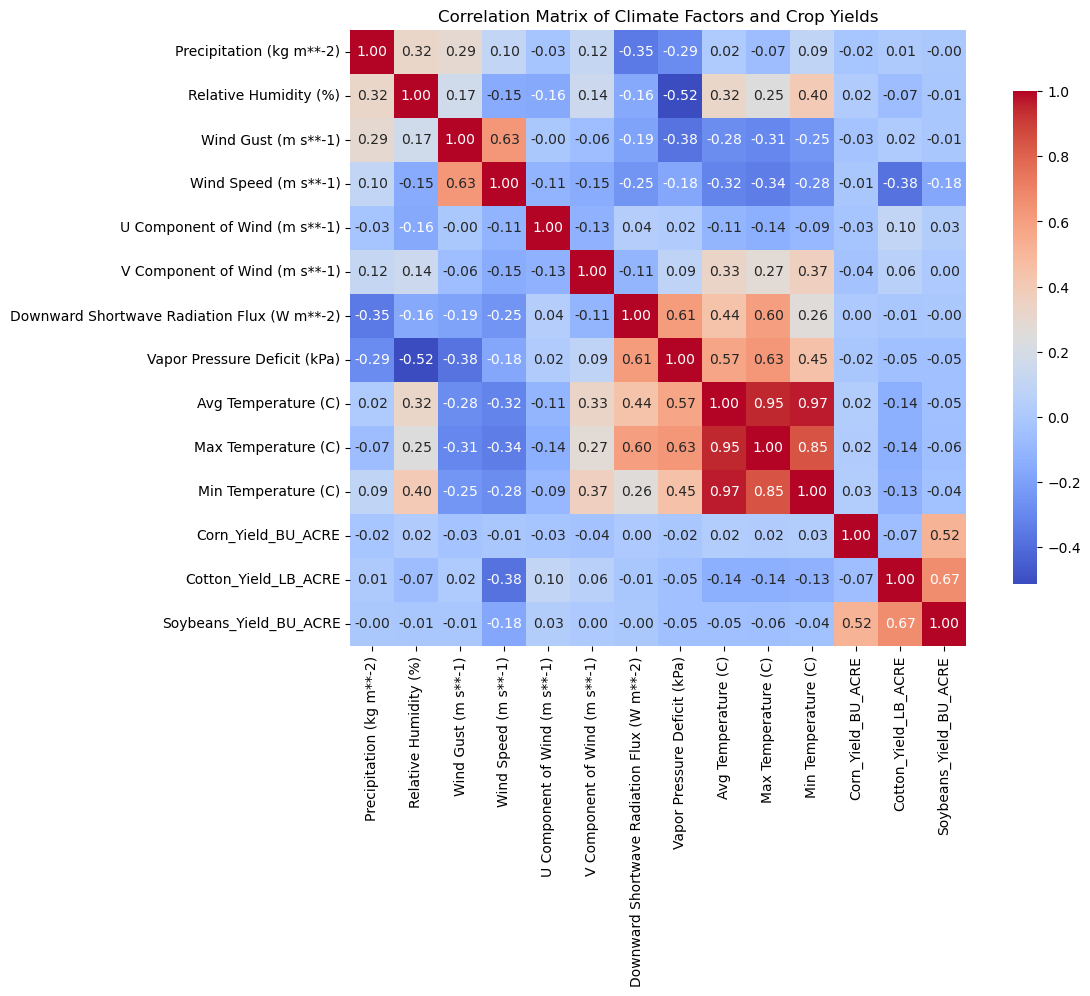


Correlations with Corn_Yield_BU_ACRE:
Corn_Yield_BU_ACRE                             1.000000
Soybeans_Yield_BU_ACRE                         0.519569
Min Temperature (C)                            0.026499
Avg Temperature (C)                            0.024196
Relative Humidity (%)                          0.019480
Max Temperature (C)                            0.018764
Downward Shortwave Radiation Flux (W m**-2)    0.001116
Wind Speed (m s**-1)                          -0.008232
Vapor Pressure Deficit (kPa)                  -0.016730
Precipitation (kg m**-2)                      -0.019394
U Component of Wind (m s**-1)                 -0.026228
Wind Gust (m s**-1)                           -0.032805
V Component of Wind (m s**-1)                 -0.037852
Cotton_Yield_LB_ACRE                          -0.065036
Name: Corn_Yield_BU_ACRE, dtype: float64

Correlations with Cotton_Yield_LB_ACRE:
Cotton_Yield_LB_ACRE                           1.000000
Soybeans_Yield_BU_ACRE                 

In [22]:
# Merge HRRR daily data with all available crop yields by FIPS
merged_df = hrrr_all_year_df.merge(
    usda_all_crops_grouped[["FIPS", "Corn_Yield_BU_ACRE", "Cotton_Yield_LB_ACRE", "Soybeans_Yield_BU_ACRE"]],
    on="FIPS",
    how="left"
)

# Drop rows where all yield columns are missing
yield_cols = ["Corn_Yield_BU_ACRE", "Cotton_Yield_LB_ACRE", "Soybeans_Yield_BU_ACRE"]
merged_df_clean = merged_df.dropna(subset=yield_cols, how="all")
print(merged_df_clean)

# Only include numeric columns in the correlation matrix
numeric_df = merged_df_clean.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Climate Factors and Crop Yields")
plt.show()

# Print correlations for each yield column
for ycol in yield_cols:
    if ycol in corr_matrix.columns:
        print(f"\nCorrelations with {ycol}:")
        print(corr_matrix[ycol].sort_values(ascending=False))




In [23]:
# Calculate daily max, min, average temperature, and total precipitation for each county
daily_stats = merged_df_clean.groupby(['Date', 'County']).agg({
    'Max Temperature (C)': 'max',
    'Min Temperature (C)': 'min',
    'Avg Temperature (C)': 'mean',
    'Precipitation (kg m**-2)': 'sum'
}).reset_index()

# Rename columns for clarity
daily_stats = daily_stats.rename(columns={
    'Max Temperature (C)': 'Daily Max Temp (C)',
    'Min Temperature (C)': 'Daily Min Temp (C)',
    'Avg Temperature (C)': 'Daily Avg Temp (C)',
    'Precipitation (kg m**-2)': 'Daily Total Precipitation (kg m**-2)'
})

daily_stats

Date      County  Daily Max Temp (C)  Daily Min Temp (C)  \
0     2022-01-01     AUTAUGA           27.026200           20.714200   
1     2022-01-01     BALDWIN           25.033148           21.943803   
2     2022-01-01     BARBOUR           27.488300           21.657433   
3     2022-01-01      BLOUNT           24.706143           20.167607   
4     2022-01-01     CALHOUN           24.384500           19.644050   
...          ...         ...                 ...                 ...   
14595 2022-12-31    RANDOLPH           16.951583           12.529750   
14596 2022-12-31     RUSSELL           18.693150           14.426250   
14597 2022-12-31      SHELBY           18.738793           13.705276   
14598 2022-12-31   TALLADEGA           18.319138           12.716241   
14599 2022-12-31  TUSCALOOSA           19.840357           14.497881   

       Daily Avg Temp (C)  Daily Total Precipitation (kg m**-2)  
0               23.045200                              0.059533  
1               23.116016                              0.660656  
2               23.765433                              0.104033  
3               21.810786                              0.033464  
4               21.526650                              0.216250  
...                   ...                                   ...  
14595           14.236417                              2.953667  
14596           16.150000                              4.796450  
14597           15.676517                              1.581103  
14598           15.303966                              2.426448  
14599           16.220071                              2.517524  

[14600 rows x 6 columns]

In [24]:
# Find the max and min temperature for each month by county
monthly_temp_stats = merged_df_clean.groupby(['County', merged_df_clean['Date'].dt.month]).agg(
    Max_Temperature=('Max Temperature (C)', 'max'),
    Min_Temperature=('Min Temperature (C)', 'min')
).reset_index().rename(columns={'Date': 'Month'})

monthly_temp_stats

County  Month  Max_Temperature  Min_Temperature
0       AUTAUGA      1        27.026200        -4.507533
1       AUTAUGA      2        25.734400        -2.248267
2       AUTAUGA      3        27.800867        -2.829600
3       AUTAUGA      4        28.785400         3.297267
4       AUTAUGA      5        32.429133        11.059800
..          ...    ...              ...              ...
475  TUSCALOOSA      8        34.977571        20.103000
476  TUSCALOOSA      9        35.597952         9.286262
477  TUSCALOOSA     10        29.122238        -0.499905
478  TUSCALOOSA     11        29.557738        -3.349286
479  TUSCALOOSA     12        24.848190       -12.663048

[480 rows x 4 columns]

In [25]:

growing_df = merged_df_clean

# Add a 'Month' column for grouping
growing_df["Month"] = growing_df["Date"].dt.month

# Group by FIPS, County, and Month for growing season stats
growing_stats_monthly = growing_df.groupby(["FIPS", "County", "Month"]).agg(
    Avg_Monthly_Temp=("Avg Temperature (C)", "mean"),
    Total_Monthly_Rainfall=("Precipitation (kg m**-2)", "sum"),
    Hot_Days=("Max Temperature (C)", lambda x: (x > 35).sum()),
    Cold_Days=("Min Temperature (C)", lambda x: (x < 10).sum()),
    Days_Without_Rain=("Precipitation (kg m**-2)", lambda x: (x == 0).sum())
).reset_index()

growing_stats_monthly

/var/folders/xq/dt50_bnd53sdn1lb28kpb16r0000gp/T/ipykernel_65277/3589894934.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growing_df["Month"] = growing_df["Date"].dt.month


FIPS      County  Month  Avg_Monthly_Temp  Total_Monthly_Rainfall  \
0    01001     AUTAUGA      1          6.947680              118.730867   
1    01001     AUTAUGA      2         12.377302              128.785400   
2    01001     AUTAUGA      3         14.638802              146.644467   
3    01001     AUTAUGA      4         17.193778              111.401333   
4    01001     AUTAUGA      5         22.897191              124.866067   
..     ...         ...    ...               ...                     ...   
475  01125  TUSCALOOSA      8         25.933892              113.820310   
476  01125  TUSCALOOSA      9         22.932455               47.344595   
477  01125  TUSCALOOSA     10         16.228704               48.740643   
478  01125  TUSCALOOSA     11         12.733302               82.523881   
479  01125  TUSCALOOSA     12          9.746571               87.628952   

     Hot_Days  Cold_Days  Days_Without_Rain  
0           0         29                 16  
1           0         12                 13  
2           0         20                 14  
3           0         12                 17  
4           0          0                 13  
..        ...        ...                ...  
475         0          0                  4  
476         1          3                 17  
477         0         18                 24  
478         0         18                 14  
479         0         18                  8  

[480 rows x 8 columns]

In [26]:
# Merge the cleaned monthly dataframe with growing_stats_monthly on common columns (e.g., FIPS and Month)
merged_monthly_df_clean["Month"] = merged_monthly_df_clean["Date"].dt.month
monthly_with_growing_stats = merged_monthly_df_clean.merge(
    growing_stats_monthly,
    on=["FIPS", "County", "Month"],
    how="left"
)
monthly_with_growing_stats = monthly_with_growing_stats.merge(
    monthly_temp_stats,
    on=["County", "Month"],
    how="left"
)
monthly_with_growing_stats

/var/folders/xq/dt50_bnd53sdn1lb28kpb16r0000gp/T/ipykernel_65277/645626077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_monthly_df_clean["Month"] = merged_monthly_df_clean["Date"].dt.month


State      County  Precipitation (kg m**-2)  Relative Humidity (%)  \
0    ALABAMA     AUTAUGA                  3.830028              68.428817   
1    ALABAMA     BALDWIN                  1.841861              72.732998   
2    ALABAMA     BARBOUR                  2.799485              66.396344   
3    ALABAMA      BLOUNT                  3.703056              66.927074   
4    ALABAMA     CALHOUN                  3.616523              66.408065   
..       ...         ...                       ...                    ...   
475  ALABAMA    RANDOLPH                  2.551949              72.814247   
476  ALABAMA     RUSSELL                  1.663276              70.803387   
477  ALABAMA      SHELBY                  2.185778              71.305784   
478  ALABAMA   TALLADEGA                  1.814436              70.809010   
479  ALABAMA  TUSCALOOSA                  2.826740              72.746851   

     Wind Gust (m s**-1)  Wind Speed (m s**-1)  U Component of Wind (m s**-1)  \
0               6.175469              4.755189                       0.429174   
1               6.853068              6.743207                       0.354913   
2               5.963249              4.273303                       0.557912   
3               6.529457              3.103699                       0.424286   
4               5.997147              2.641298                       0.441879   
..                   ...                   ...                            ...   
475             5.463823              1.988992                       0.022833   
476             5.213405              4.108224                      -0.380623   
477             5.540979              2.989755                      -0.022644   
478             5.475393              2.568059                       0.005692   
479             5.961694              4.350012                      -0.130550   

     V Component of Wind (m s**-1)  \
0                        -1.321458   
1                        -1.749422   
2                        -0.843831   
3                        -0.774506   
4                        -0.603531   
..                             ...   
475                      -0.016608   
476                      -0.123111   
477                       0.193202   
478                       0.256227   
479                       0.602714   

     Downward Shortwave Radiation Flux (W m**-2)  \
0                                    2889.922151   
1                                    3034.614490   
2                                    3009.552258   
3                                    2718.283641   
4                                    2661.870323   
..                                           ...   
475                                  2122.408602   
476                                  2357.000000   
477                                  2174.905451   
478                                  2168.414572   
479                                  2099.143088   

     Vapor Pressure Deficit (kPa)  ...  Soybeans_Yield_BU_ACRE  \
0                        0.355817  ...                     NaN   
1                        0.342061  ...                    37.1   
2                        0.417730  ...                     NaN   
3                        0.318297  ...                    37.4   
4                        0.330081  ...                    45.5   
..                            ...  ...                     ...   
475                      0.288927  ...                     NaN   
476                      0.375398  ...                     NaN   
477                      0.339212  ...                     NaN   
478                      0.340849  ...                    46.3   
479                      0.325164  ...                    39.2   

     WinterWheat_Yield_BU_ACRE  Month Avg_Monthly_Temp Total_Monthly_Rainfall  \
0                          NaN      1         6.947680             118.730867   
1                          NaN      1         9.283907              57.0

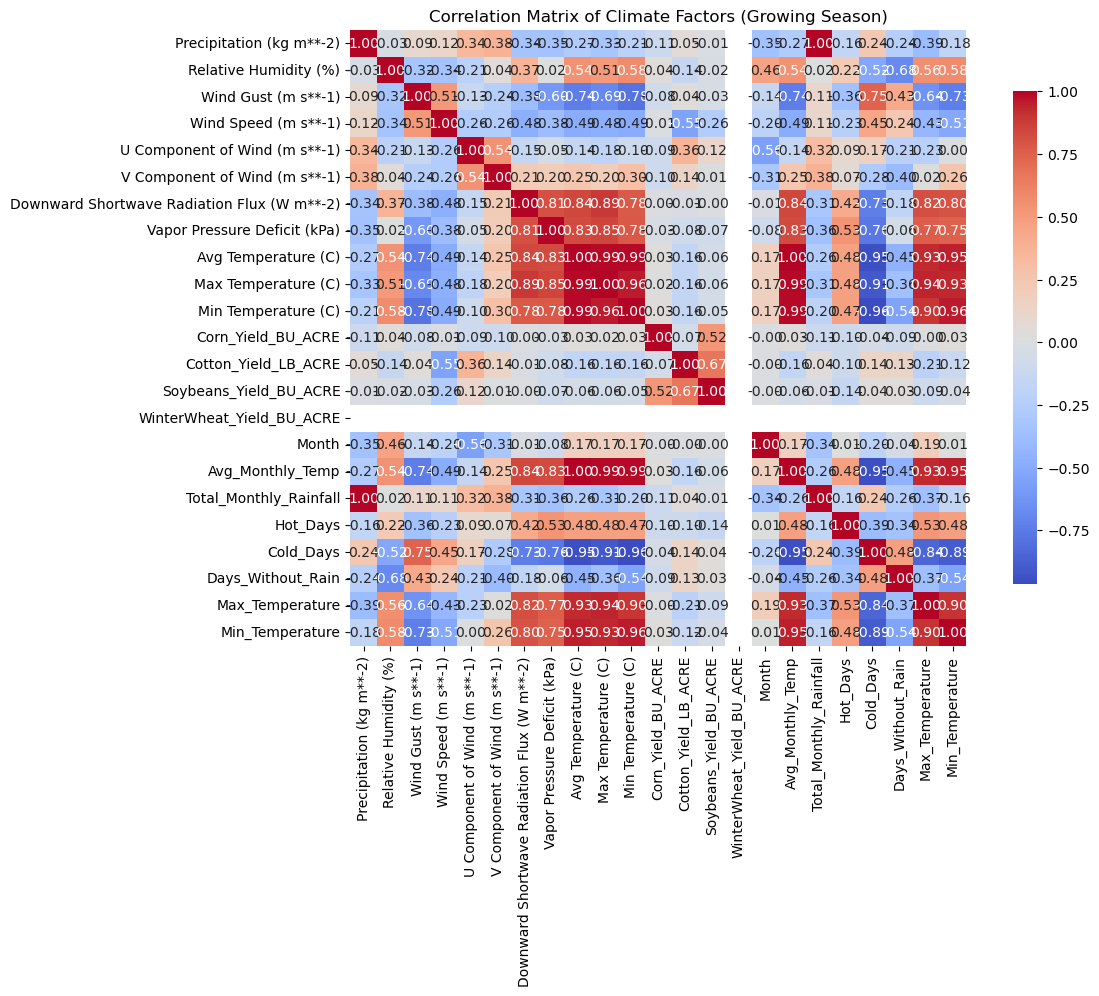


Correlations with Corn_Yield_BU_ACRE:
Corn_Yield_BU_ACRE                             1.000000e+00
Soybeans_Yield_BU_ACRE                         5.195694e-01
Relative Humidity (%)                          3.997718e-02
Min Temperature (C)                            3.333148e-02
Min_Temperature                                3.185435e-02
Avg_Monthly_Temp                               2.854253e-02
Avg Temperature (C)                            2.854253e-02
Max Temperature (C)                            2.187451e-02
Downward Shortwave Radiation Flux (W m**-2)    2.017589e-03
Month                                         -9.697939e-16
Max_Temperature                               -4.491862e-03
Wind Speed (m s**-1)                          -1.135745e-02
Vapor Pressure Deficit (kPa)                  -2.539708e-02
Cold_Days                                     -4.442362e-02
Cotton_Yield_LB_ACRE                          -6.503628e-02
Wind Gust (m s**-1)                           -7.648258e-02
D

In [27]:
# Only include numeric columns for the growing season DataFrame
numeric_df = monthly_with_growing_stats.select_dtypes(include=["number"])

# Compute correlation matrix for growing season
growing_corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(growing_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Climate Factors (Growing Season)")
plt.show()

# Print correlations for each available yield column
for ycol in yield_cols:
    if ycol in growing_corr_matrix.columns:
        print(f"\nCorrelations with {ycol}:")
        print(growing_corr_matrix[ycol].sort_values(ascending=False))

In [28]:
# --- Derived Indicators for Each County by Month ---

# Ensure 'Month' column exists
growing_df["Month"] = growing_df["Date"].dt.month

# 1. Growing Degree Days (GDD) per day
BASE_TEMP = 10  # °C
growing_df["GDD"] = (growing_df["Avg Temperature (C)"] - BASE_TEMP).clip(lower=0)

# 2. Rainfall Variability (std dev of daily rainfall) by month
rainfall_variability_month = (
    growing_df.groupby(["FIPS", "County", "Month"])["Precipitation (kg m**-2)"]
    .std()
    .reset_index()
    .rename(columns={"Precipitation (kg m**-2)": "Rainfall_Variability"})
)

# 3. Heat Stress Index: max consecutive days above 33°C (per county, per month)
def max_consecutive_heat_days_month(df, temp_col="Max Temperature (C)", threshold=33):
    df = df.sort_values("Date")
    is_hot = df[temp_col] > threshold
    max_streak = streak = 0
    for hot in is_hot:
        if hot:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

heat_stress_month = (
    growing_df.groupby(["FIPS", "County", "Month"], group_keys=False)
    .apply(lambda df: max_consecutive_heat_days_month(df, "Max Temperature (C)", 33))
    .reset_index(name="Max_Consecutive_Heat_Days")
)

# 4. Drought Periods: max consecutive days with <1mm rain (per county, per month)
def max_consecutive_drought_days_month(df, rain_col="Precipitation (kg m**-2)", threshold=1.0):
    df = df.sort_values("Date")
    is_dry = df[rain_col] < threshold
    max_streak = streak = 0
    for dry in is_dry:
        if dry:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

drought_periods_month = (
    growing_df.groupby(["FIPS", "County", "Month"], group_keys=False)
    .apply(lambda df: max_consecutive_drought_days_month(df, "Precipitation (kg m**-2)", 1.0))
    .reset_index(name="Max_Consecutive_Drought_Days")
)

# 5. Total GDD for each month (per county)
gdd_total_month = (
    growing_df.groupby(["FIPS", "County", "Month"])["GDD"]
    .sum()
    .reset_index()
    .rename(columns={"GDD": "Total_GDD"})
)

# --- Merge all derived indicators into growing_stats_monthly ---
growing_stats_monthly_derived = (
    monthly_with_growing_stats
    .merge(gdd_total_month, on=["FIPS", "County", "Month"], how="left")
    .merge(rainfall_variability_month, on=["FIPS", "County", "Month"], how="left")
    .merge(heat_stress_month, on=["FIPS", "County", "Month"], how="left")
    .merge(drought_periods_month, on=["FIPS", "County", "Month"], how="left")
)

growing_stats_monthly_derived

/var/folders/xq/dt50_bnd53sdn1lb28kpb16r0000gp/T/ipykernel_65277/496403916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growing_df["Month"] = growing_df["Date"].dt.month
/var/folders/xq/dt50_bnd53sdn1lb28kpb16r0000gp/T/ipykernel_65277/496403916.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growing_df["GDD"] = (growing_df["Avg Temperature (C)"] - BASE_TEMP).clip(lower=0)
/var/folders/xq/dt50_bnd53sdn1lb28kpb16r0000gp/T/ipykernel_65277/496403916.py:33: DeprecationWarning: DataFrameGroupBy.apply o

State      County  Precipitation (kg m**-2)  Relative Humidity (%)  \
0    ALABAMA     AUTAUGA                  3.830028              68.428817   
1    ALABAMA     BALDWIN                  1.841861              72.732998   
2    ALABAMA     BARBOUR                  2.799485              66.396344   
3    ALABAMA      BLOUNT                  3.703056              66.927074   
4    ALABAMA     CALHOUN                  3.616523              66.408065   
..       ...         ...                       ...                    ...   
475  ALABAMA    RANDOLPH                  2.551949              72.814247   
476  ALABAMA     RUSSELL                  1.663276              70.803387   
477  ALABAMA      SHELBY                  2.185778              71.305784   
478  ALABAMA   TALLADEGA                  1.814436              70.809010   
479  ALABAMA  TUSCALOOSA                  2.826740              72.746851   

     Wind Gust (m s**-1)  Wind Speed (m s**-1)  U Component of Wind (m s**-1)  \
0               6.175469              4.755189                       0.429174   
1               6.853068              6.743207                       0.354913   
2               5.963249              4.273303                       0.557912   
3               6.529457              3.103699                       0.424286   
4               5.997147              2.641298                       0.441879   
..                   ...                   ...                            ...   
475             5.463823              1.988992                       0.022833   
476             5.213405              4.108224                      -0.380623   
477             5.540979              2.989755                      -0.022644   
478             5.475393              2.568059                       0.005692   
479             5.961694              4.350012                      -0.130550   

     V Component of Wind (m s**-1)  \
0                        -1.321458   
1                        -1.749422   
2                        -0.843831   
3                        -0.774506   
4                        -0.603531   
..                             ...   
475                      -0.016608   
476                      -0.123111   
477                       0.193202   
478                       0.256227   
479                       0.602714   

     Downward Shortwave Radiation Flux (W m**-2)  \
0                                    2889.922151   
1                                    3034.614490   
2                                    3009.552258   
3                                    2718.283641   
4                                    2661.870323   
..                                           ...   
475                                  2122.408602   
476                                  2357.000000   
477                                  2174.905451   
478                                  2168.414572   
479                                  2099.143088   

     Vapor Pressure Deficit (kPa)  ...  Total_Monthly_Rainfall  Hot_Days  \
0                        0.355817  ...              118.730867         0   
1                        0.342061  ...               57.097705         0   
2                        0.417730  ...               86.784033         0   
3                        0.318297  ...              114.794750         0   
4                        0.330081  ...              112.112200         0   
..                            ...  ...                     ...       ...   
475                      0.288927  ...               79.110417         0   
476                      0.375398  ...               51.561550         0   
477                      0.339212  ...               67.759103         0   
478                      0.340849  ...               56.247517         0   
479                      0.325164  ...               87.628952         0   

     Cold_Days Days_Without_Rain Max_Temperature  Min_Temperature  Total_GDD  \
0           29                16  

In [ ]:
growing_stats_monthly_derived = growing_stats_monthly_derived.fillna(0)
growing_stats_monthly_derived.drop(columns=["Date"], inplace=True, errors='ignore')
growing_stats_monthly_derived.dtypes

State                                           object
County                                          object
Precipitation (kg m**-2)                       float64
Relative Humidity (%)                          float64
Wind Gust (m s**-1)                            float64
Wind Speed (m s**-1)                           float64
U Component of Wind (m s**-1)                  float64
V Component of Wind (m s**-1)                  float64
Downward Shortwave Radiation Flux (W m**-2)    float64
Vapor Pressure Deficit (kPa)                   float64
Avg Temperature (C)                            float64
Max Temperature (C)                            float64
Min Temperature (C)                            float64
FIPS                                            object
Corn_Yield_BU_ACRE                             float64
Cotton_Yield_LB_ACRE                           float64
Soybeans_Yield_BU_ACRE                         float64
WinterWheat_Yield_BU_ACRE                      float64
Month     

: 

In [ ]:
# -------------------------
# SETUP & IMPORTS
# -------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# -------------------------
# 1) LOAD & PREPROCESS DATA
# -------------------------
df = growing_stats_monthly_derived.copy()  # <-- replace with your actual DataFrame name

# Ensure Month column exists; if not, generate by assuming ordered 12 months per county
if "Month" not in df.columns:
    df["Month"] = df.groupby("County").cumcount() + 1



# Drop target columns from features
targets = ["Corn_Yield_BU_ACRE", "Cotton_Yield_LB_ACRE", "Soybeans_Yield_BU_ACRE"]
id_cols = ["County", "Month", "State"]

feature_cols = [col for col in df.columns if col not in id_cols + targets]

# Check missing values before scaling
if df[feature_cols].isnull().any().any():
    print("Warning: Missing values found in features. Filling with column means.")
    df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())

# Normalize numerical features
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# -------------------------
# 2) SEQUENCE PREPARATION
# -------------------------
df.sort_values(by=["County", "Month"], inplace=True)

X, y = [], []
skipped_counties = []

for county, group in df.groupby("County"):
    if len(group) != 12:
        print(f"Skipping county {county}: has {len(group)} months, expected 12.")
        skipped_counties.append(county)
        continue
    seq_features = group[feature_cols].values.flatten()
    X.append(seq_features)
    y.append(group[targets].iloc[0].values)

X = np.array(X)
y = np.array(y)

print(f"Prepared sequences for {X.shape[0]} counties. Skipped {len(skipped_counties)} counties.")

# -------------------------
# 3) SPLIT DATA
# -------------------------
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# -------------------------
# 4) DEFINE DATASET & DATALOADERS
# -------------------------
class YieldDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(YieldDataset(X_train, y_train), batch_size=8, shuffle=True)
val_loader = DataLoader(YieldDataset(X_val, y_val), batch_size=8)

# -------------------------
# 5) DEFINE BASELINE MODEL
# -------------------------
class FeedforwardModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model = FeedforwardModel(X.shape[1], y.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -------------------------
# 6) TRAINING LOOP
# -------------------------
epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}")

# -------------------------
# 7) PLOT TRAINING LOSS
# -------------------------
plt.figure(figsize=(8,4))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()

# -------------------------
# 8) EVALUATION ON VALIDATION
# -------------------------
model.eval()
val_preds, val_trues = [], []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        val_preds.append(preds)
        val_trues.append(y_batch.numpy())

val_preds = np.vstack(val_preds)
val_trues = np.vstack(val_trues)

results = []

for i, target in enumerate(targets):
    mse = mean_squared_error(val_trues[:, i], val_preds[:, i])
    mae = mean_absolute_error(val_trues[:, i], val_preds[:, i])
    r2 = r2_score(val_trues[:, i], val_preds[:, i])
    results.append({"Target": target, "MSE": mse, "MAE": mae, "R2": r2})
    print(f"\nValidation Metrics for {target}:")
    print(f"  MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    
    # Scatter plot actual vs predicted
    plt.figure(figsize=(6,6))
    plt.scatter(val_trues[:, i], val_preds[:, i], alpha=0.5)
    plt.plot([val_trues[:, i].min(), val_trues[:, i].max()],
             [val_trues[:, i].min(), val_trues[:, i].max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted: {target}")
    plt.grid()
    plt.show()

results_df = pd.DataFrame(results)
print("\nSummary of Validation Metrics:\n", results_df)

# -------------------------
# 9) SAVE MODEL
# -------------------------
torch.save(model.state_dict(), "baseline_feedforward_model.pth")
print("Model weights saved as 'baseline_feedforward_model.pth'.")


Prepared sequences for 40 counties. Skipped 0 counties.
Train shape: (28, 288), Val shape: (6, 288), Test shape: (6, 288)


In [ ]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# --- 1. Select features and target ---
features = [
    'Relative Humidity (%)',
    'Min Temperature (C)',
    'Avg Temperature (C)',
    'Precipitation (kg m**-2)',
    'Wind Speed (m s**-1)',
    'Max Temperature (C)',
    'Downward Shortwave Radiation Flux (W m**-2)',
    'U Component of Wind (m s**-1)',
    'V Component of Wind (m s**-1)',
    'Wind Gust (m s**-1)',
    'Vapor Pressure Deficit (kPa)',
    'County',  # Categorical feature
]
target = 'YIELD, MEASURED IN BU / ACRE'

# --- 2. Prepare X and y ---
X = merged_df_clean[features].copy()
y = merged_df_clean[target].copy()

# --- 3. Encode categorical features ---
le_county = LabelEncoder()
X['County'] = le_county.fit_transform(X['County'])

# --- 4. Normalize numerical features ---
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[X.columns.difference(['County'])] = scaler.fit_transform(X[X.columns.difference(['County'])])

# --- 5. Check multicollinearity (remove highly correlated features) ---
corr_matrix = X_scaled.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_scaled = X_scaled.drop(columns=to_drop)

# --- 6. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- 7. Baseline model: simple MLP with TensorFlow ---
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    verbose=0
)

# --- 8. Evaluate model ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

print("Train MSE:", mean_squared_error(y_train, y_train_pred))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test MSE:", mean_squared_error(y_test, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

# --- 9. Plot actual vs predicted ---
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Yield (BU/ACRE)')
plt.ylabel('Predicted Yield (BU/ACRE)')
plt.title('Actual vs Predicted Yield (Test Set)')
plt.tight_layout()
plt.show()